In [ ]:
'''
文件重命名建议
推荐命名：
utr_expression_multidimensional_analysis.py 或 luciferase_condition_dependent_analysis.py
代码描述
项目概述
这是一个全面分析UTR序列在不同实验条件下表达水平的数据分析脚本。通过多维度可视化方法，系统评估时间点、剂量、细胞系等实验条件对UTR介导的荧光素酶表达的影响，并深入分析序列的稳定性和表达模式。
主要功能模块
1. 数据加载与预处理

加载荧光素酶筛选实验数据（vMay14_luciferase_screening_summary_log2.csv）
创建二元标签：识别相对于RY01和RY07基准的高表达序列（log2FC > 1）
统计分析：计算高表达序列的数量和比例

2. 单维度条件分析
小提琴图分析：

按时间点（16h, 48h）分析表达分布
按剂量（3.125-25ng）分析剂量依赖性
按细胞系（C2C12, HepG2）分析细胞特异性
标注样本数量和高表达比例

3. 多维度组合分析
分面网格（Facet Grid）：

三种视角组合：

时间点为X轴，剂量×细胞系为子图
细胞系为X轴，剂量×时间点为子图
剂量为X轴，时间点×细胞系为子图


每个子图显示详细统计信息

4. 热图分析
三类热图可视化：
核心维度热图：

展示Top 50序列在不同条件下的表达模式
分别分析时间点、剂量、细胞系维度
浅灰色背景增强视觉对比

组合条件热图：

时间点-剂量组合分析
按细胞系分组展示
识别最佳实验条件组合

稳定性热图：

变异系数（CV%）热图：展示序列表达稳定性
平均表达水平热图：展示序列表达强度

5. 基准比较分析
RY01 vs RY07对比：

散点图展示两个基准的相关性
四象限分析：

双高表达区域
RY01特异高表达
RY07特异高表达
双低表达区域


计算Pearson相关系数
细胞系特异性比较

6. 序列稳定性评估
稳定性指标：

计算变异系数（CV%）：评估表达稳定性
要求至少5个数据点确保统计可靠性
识别高稳定性序列（低CV%）

稳定性vs表达水平分析：

散点图展示稳定性-表达水平关系
颜色编码样本数量
标注理想阈值：

良好稳定性：CV < 15%
高表达：log2FC > 1.0


识别兼具高表达和高稳定性的"理想"序列

输出文件
可视化图表（保存于./UTR_sequences/）：

条件分析小提琴图
分面网格图
多种热图（维度、组合、稳定性）
基准比较散点图
稳定性分析图

数据文件：

vMay16_Dimension_Rankings.csv：各维度下的序列排名
vMay16_Best_Sequences_By_CellLine.csv：细胞系特异最佳序列
vMay16_Best_Conditions_By_CellLine.csv：最佳实验条件组合
vMay16_Top_Stable_Sequences.csv：高稳定性序列列表
vMay16_Sequence_Rankings.csv：综合排名

分析特点
多维度评估：

单因素、双因素、三因素组合分析
全面覆盖实验设计空间

统计严谨：

变异系数评估稳定性
多重比较和排名
样本量考虑

实用导向：

识别最佳实验条件
筛选稳定高效序列
提供可操作的序列列表

应用价值

条件优化：确定最佳实验条件组合
序列筛选：识别稳定高表达的UTR序列
细胞特异性：理解序列的细胞系依赖性
质量控制：通过稳定性分析评估数据可靠性
决策支持：为后续实验设计提供数据支撑
'''

In [ ]:
import RNA
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [13]:
data = pd.read_csv('~/UTR_yd/UTR_sequences/vMay14_luciferase_screening_summary_log2.csv', index_col = 0)
print(data.columns)
print(f"Total number of samples: {len(data)}")

# Create binary labels for positive expression
data['RY07_positive'] = data['RY07_FC_log2RLU'] > 1
data['RY01_positive'] = data['RY01_FC_log2RLU'] > 1

# Count positive samples
ry07_positive_count = data['RY07_positive'].sum()
ry01_positive_count = data['RY01_positive'].sum()
print(f"Samples with RY07_FC_log2RLU > 1: {ry07_positive_count} ({ry07_positive_count/len(data)*100:.1f}%)")
print(f"Samples with RY01_FC_log2RLU > 1: {ry01_positive_count} ({ry01_positive_count/len(data)*100:.1f}%)")
data

Index(['rvac_ID', 'Molecule', 'Batch_date', 'Plate', 'Time Points(h)',
       'Dosage (ng)', 'source', 'RLU_AVG', 'RLU_SD', 'RLU_CV', 'RY07_RLU',
       'RY07_RLU_CV', 'RY07_FC_log2RLU', 'RY07_FC_Raw', 'RY01_RLU',
       'RY01_RLU_CV', 'RY01_FC_log2RLU', 'RY01_FC_Raw', 'cds', 'Cell_Line',
       'note', 'Description', 'Projects', 'RVAC ID', '5' UTR', '3' UTR',
       'exists_in_utr_luci', 'class', 'full_sequence', 'is_train', 'is_test',
       'is_val', 'cell_type', 'sequence'],
      dtype='object')
Total number of samples: 6160
Samples with RY07_FC_log2RLU > 1: 3786 (61.5%)
Samples with RY01_FC_log2RLU > 1: 3686 (59.8%)


rvac_ID  Molecule  Batch_date  Plate  Time Points(h)  Dosage (ng)  \
0     RV-UML-m379       379    20221021     18              48         6.25   
1     RV-UML-m390       390    20221021     18              48         6.25   
2     RV-UML-m392       392    20221021     18              48         6.25   
3     RV-UML-m381       381    20221021     18              48         6.25   
4     RV-UML-m386       386    20221021     18              48         6.25   
...           ...       ...         ...    ...             ...          ...   
6155  RV-UML-m213       213    20221007      1              16         6.25   
6156  RV-UML-m213       213    20221007      9              48        12.50   
6157  RV-UML-m268       268    20221007      6              16        25.00   
6158  RV-UML-m268       268    20221007      6              16        12.50   
6159  RV-UML-m268       268    20221007     14              48        25.00   

     source  RLU_AVG  RLU_SD  RLU_CV  ...  exists_in_utr_luci  \
0       NaN    12960    2480    0.19  ...                True   
1       NaN     9820    2900    0.30  ...                True   
2       NaN    10060    1100    0.11  ...                True   
3       NaN     6880     280    0.04  ...                True   
4       NaN     6820     900    0.13  ...                True   
...     ...      ...     ...     ...  ...                 ...   
6155    NaN      100      20    0.20  ...                True   
6156    NaN       40       0    0.00  ...                True   
6157    NaN      640     200    0.31  ...                True   
6158    NaN      220      60    0.27  ...                True   
6159    NaN      100      20    0.20  ...                True   

                         class  \
0     Luciferase-HepG2-48-6.25   
1     Luciferase-HepG2-48-6.25   
2     Luciferase-HepG2-48-6.25   
3     Luciferase-HepG2-48-6.25   
4     Luciferase-HepG2-48-6.25   
...                        ...   
6155  Luciferase-C2C12-16-6.25   
6156  Luciferase-C2C12-48-12.5   
6157  Luciferase-C2C12-16-25.0   
6158  Luciferase-C2C12-16-12.5   
6159  Luciferase-C2C12-48-25.0   

                                          full_sequence  is_train  is_test  \
0     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...      True    False   
1     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...      True    False   
2     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...      True    False   
3     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...      True    False   
4     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...      True    False   
...                                                 ...       ...      ...   
6155  AGAAGATGAAGCCTGAACTGATTATAAAACCTTCCTTGGCTCAGTG...      True    False   
6156  AGAAGATGAAGCCTGAACTGATTATAAAACCTTCCTTGGCTCAGTG...      True    False   
6157  AGCCGTCTCCGCCTCGCCGCAGTCGGGGCAGCCGCTCGCCCCTCTT...      True    False   
6158  AGCCGTCTCCGCCTCGCCGCAGTCGGGGCAGCCGCTCGCCCCTCTT...      True    False   
6159  AGCCGTCTCCGCCTCGCCGCAGTCGGGGCAGCCGCTCGCCCCTCTT...      True    False   

      is_val                 cell_type  \
0      False  Luciferase-HepG2-48-6.25   
1      False  Luciferase-HepG2-48-6.25   
2      False  Luciferase-HepG2-48-6.25   
3      False  Luciferase-HepG2-48-6.25   
4      False  Luciferase-HepG2-48-6.25   
...      ...                       ...   
6155   False  Luciferase-C2C12-16-6.25   
6156   False  Luciferase-C2C12-48-12.5   
6157   False  Luciferase-C2C12-16-25.0   
6158   False  Luciferase-C2C12-16-12.5   
6159   False  Luciferase-C2C12-48-25.0   

                                               sequence RY07_positive  \
0     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...          True   
1     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...          True   
2     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...          True   
3     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...          True   
4     AGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACC...         

In [15]:
def analyze_by_condition(data, condition, target, benchmark):
    """Analyze expression levels by a specific condition."""
    plt.figure(figsize=(10, 6))
    
    if condition in ['Time Points(h)', 'Dosage (ng)']:
        # For numerical conditions, create box plots
        ax = sns.boxplot(x=condition, y=target, data=data)
        
        # Add a horizontal line at log2FC = 1 to indicate positive expression
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Positive Expression Threshold')
        
        # Add swarm plot to show individual data points
        sns.swarmplot(x=condition, y=target, data=data, color='black', alpha=0.5, size=4)
        
        # Add count and percentage above each box
        for i, level in enumerate(sorted(data[condition].unique())):
            subset = data[data[condition] == level]
            positive_count = sum(subset[target] > 1)
            percentage = positive_count / len(subset) * 100 if len(subset) > 0 else 0
            plt.text(i, ax.get_ylim()[1] * 0.9, 
                    f"n={len(subset)}\n{positive_count}/{len(subset)}\n({percentage:.1f}%)", 
                    horizontalalignment='center')
    else:
        # For categorical conditions like Cell_Line
        ax = sns.boxplot(x=condition, y=target, data=data)
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Positive Expression Threshold')
        sns.swarmplot(x=condition, y=target, data=data, color='black', alpha=0.5, size=4)
        
        # Add count and percentage above each box
        for i, cell in enumerate(data[condition].unique()):
            subset = data[data[condition] == cell]
            positive_count = sum(subset[target] > 1)
            percentage = positive_count / len(subset) * 100 if len(subset) > 0 else 0
            plt.text(i, ax.get_ylim()[1] * 0.9, 
                    f"n={len(subset)}\n{positive_count}/{len(subset)}\n({percentage:.1f}%)", 
                    horizontalalignment='center')
    
    plt.title(f'Expression Levels ({benchmark} Benchmark) by {condition}')
    plt.ylabel(f'{target} (log2 Fold Change)')
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'expression_{benchmark}_by_{condition.replace(" ", "_")}.png')
    plt.show()

def create_facet_grid(data, target, benchmark):
    """Create a facet grid to analyze expression across Cell Lines and Time Points."""
    plt.figure(figsize=(15, 8))
    g = sns.FacetGrid(data, col='Cell_Line', row='Dosage (ng)', height=4, aspect=1.2)
    g.map_dataframe(sns.boxplot, x='Time Points(h)', y=target)
    g.map_dataframe(sns.swarmplot, x='Time Points(h)', y=target, color='black', alpha=0.5, size=4)
    
    # Add horizontal line at y=1 for each subplot
    for ax in g.axes.flat:
        ax.axhline(y=1, color='r', linestyle='--', alpha=0.7)
    
    # Add title and labels
    g.fig.suptitle(f'Expression Levels ({benchmark} Benchmark) by Cell Line, Dosage, and Time Points', fontsize=16)
    g.set_axis_labels('Time Points (h)', f'{target} (log2 Fold Change)')
    g.fig.subplots_adjust(top=0.9)
    plt.tight_layout()
    #plt.savefig(f'expression_{benchmark}_facet_grid.png')
    plt.show()

def create_heatmap(data, target, benchmark):
    """Create a heatmap of average expression levels across Time Points and Dosages."""
    # Pivot the data to create a matrix of Time Points vs Dosage
    pivot_table = pd.pivot_table(
        data=data,
        values=target,
        index='Time Points(h)',
        columns='Dosage (ng)',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', center=1, 
                vmin=-1, vmax=3, fmt='.2f', linewidths=.5)
    plt.title(f'Average {target} Expression Levels ({benchmark} Benchmark)')
    plt.tight_layout()
    #plt.savefig(f'heatmap_{benchmark}_time_vs_dosage.png')
    plt.show()
    
    # Also create percentage heatmap for positive expression
    def percentage_positive(x):
        return (x > 1).mean() * 100
    
    pivot_percentage = pd.pivot_table(
        data=data,
        values=target,
        index='Time Points(h)',
        columns='Dosage (ng)',
        aggfunc=percentage_positive
    )
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_percentage, annot=True, cmap='YlGnBu', 
                vmin=0, vmax=100, fmt='.1f', linewidths=.5)
    plt.title(f'Percentage of UTRs with Positive Expression ({benchmark} Benchmark)')
    plt.tight_layout()
    #plt.savefig(f'heatmap_percentage_{benchmark}_time_vs_dosage.png')
    plt.show()

def compare_benchmarks(data):
    """Directly compare expression levels between RY07 and RY01 benchmarks."""
    plt.figure(figsize=(10, 8))
    
    # Scatter plot comparing RY07 vs RY01 expression
    plt.scatter(data['RY07_FC_log2RLU'], data['RY01_FC_log2RLU'], alpha=0.6)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='RY01 Positive Threshold')
    plt.axvline(x=1, color='b', linestyle='--', alpha=0.5, label='RY07 Positive Threshold')
    
    # Add quadrant labels
    plt.text(2.5, 2.5, 'Positive in Both', fontsize=12, ha='center')
    plt.text(2.5, 0, 'RY07+ / RY01-', fontsize=12, ha='center')
    plt.text(0, 2.5, 'RY07- / RY01+', fontsize=12, ha='center')
    plt.text(0, 0, 'Negative in Both', fontsize=12, ha='center')
    
    # Calculate correlation
    correlation = data['RY07_FC_log2RLU'].corr(data['RY01_FC_log2RLU'])
    plt.annotate(f'Correlation: {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
    
    # Add counts for each quadrant
    q1 = ((data['RY07_FC_log2RLU'] > 1) & (data['RY01_FC_log2RLU'] > 1)).sum()
    q2 = ((data['RY07_FC_log2RLU'] <= 1) & (data['RY01_FC_log2RLU'] > 1)).sum()
    q3 = ((data['RY07_FC_log2RLU'] <= 1) & (data['RY01_FC_log2RLU'] <= 1)).sum()
    q4 = ((data['RY07_FC_log2RLU'] > 1) & (data['RY01_FC_log2RLU'] <= 1)).sum()
    
    plt.annotate(f'n = {q1}', xy=(2.5, 2.2), ha='center')
    plt.annotate(f'n = {q4}', xy=(2.5, 0.3), ha='center')
    plt.annotate(f'n = {q2}', xy=(0.3, 2.2), ha='center')
    plt.annotate(f'n = {q3}', xy=(0.3, 0.3), ha='center')
    
    plt.xlabel('RY07_FC_log2RLU')
    plt.ylabel('RY01_FC_log2RLU')
    plt.title('Comparison of Expression Levels: RY07 vs RY01 Benchmarks')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    #plt.savefig('benchmark_comparison.png')
    plt.show()
    
    # Additional analysis: Expression level distributions
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data['RY07_FC_log2RLU'], kde=True)
    plt.axvline(x=1, color='r', linestyle='--')
    plt.title('Distribution of RY07_FC_log2RLU')
    plt.xlabel('log2 Fold Change')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data['RY01_FC_log2RLU'], kde=True)
    plt.axvline(x=1, color='r', linestyle='--')
    plt.title('Distribution of RY01_FC_log2RLU')
    plt.xlabel('log2 Fold Change')
    
    plt.tight_layout()
    #plt.savefig('expression_distributions.png')
    plt.show()

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 53.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 52.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 47.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 44.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


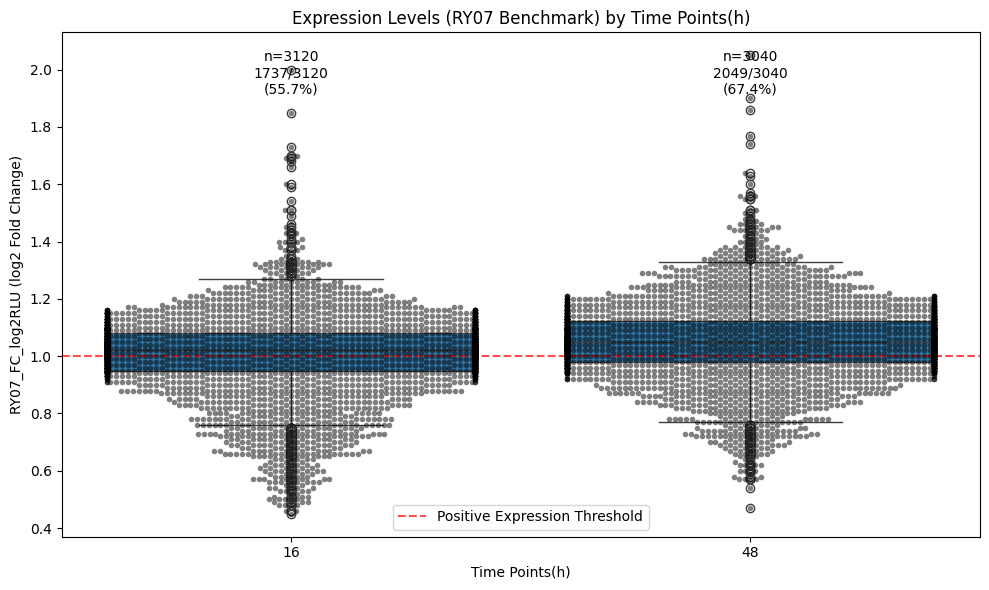

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 32.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 24.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


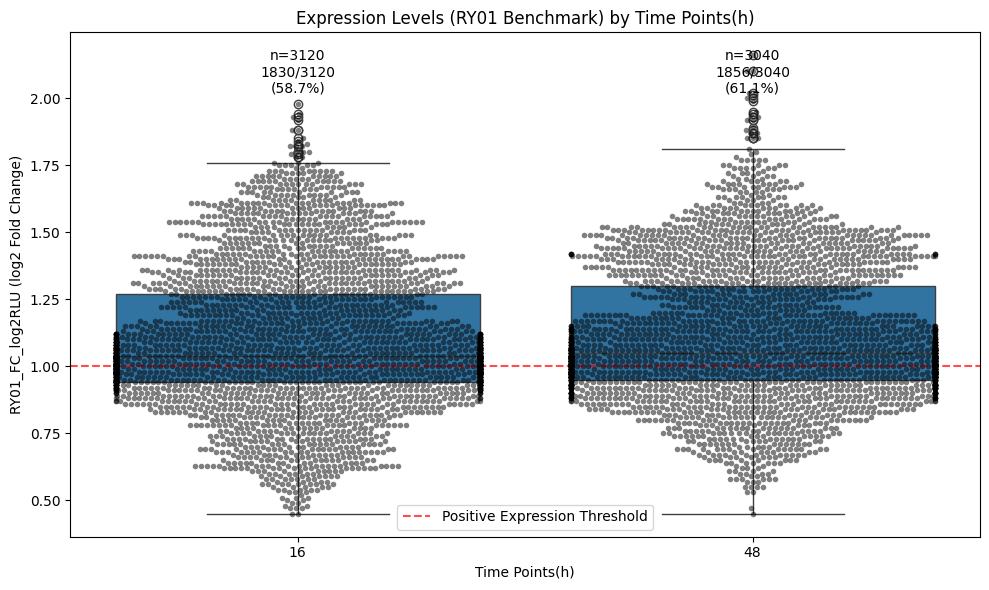

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 59.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 52.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 50.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 63.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


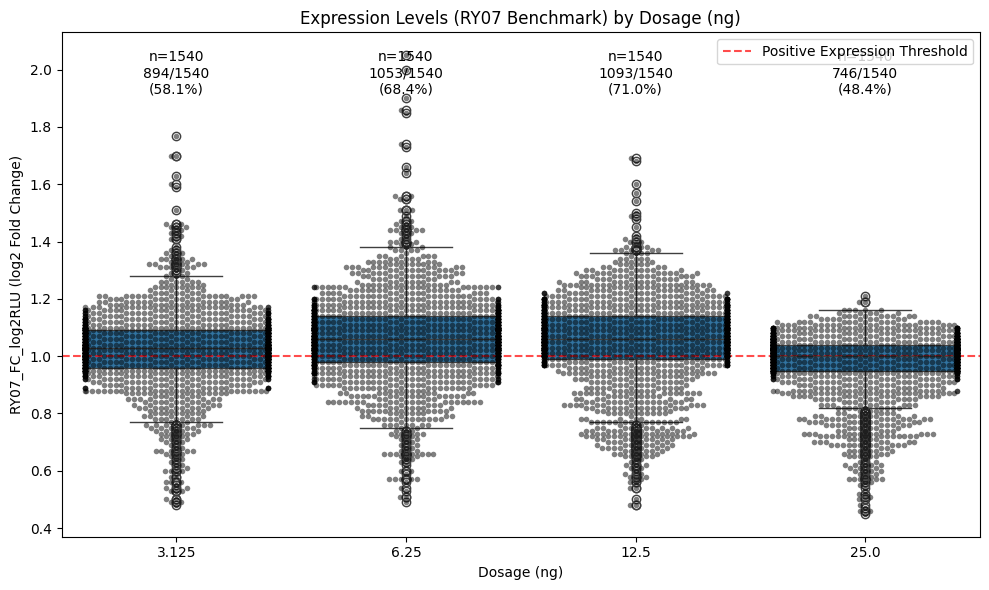

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 37.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 29.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


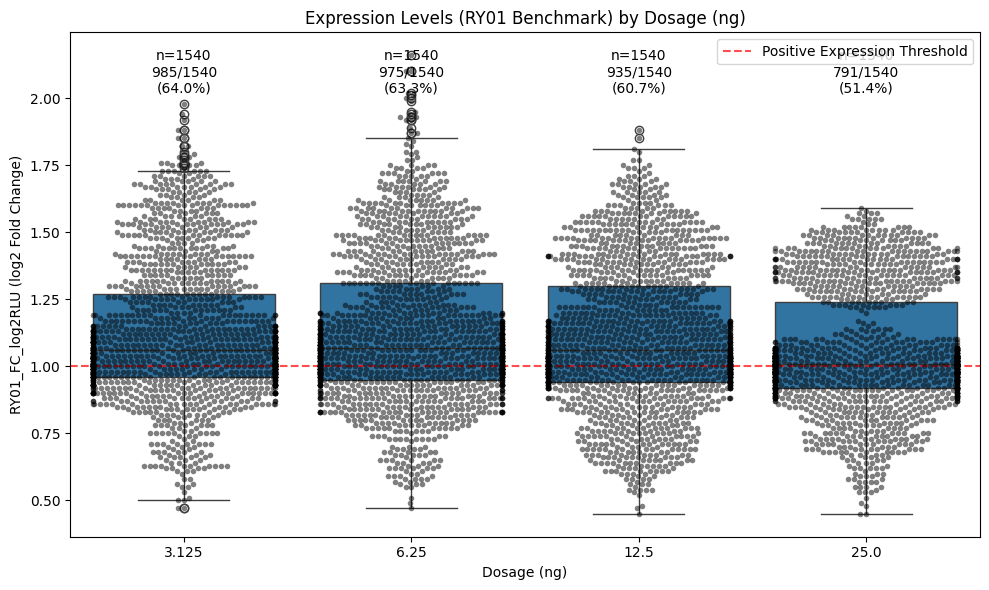

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 48.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 40.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 53.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


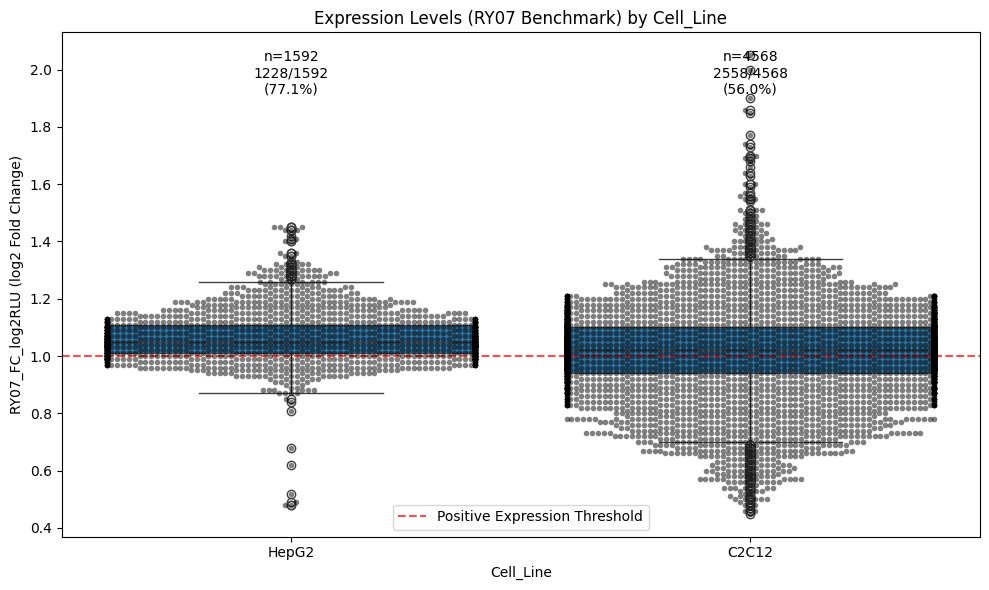

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 19.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 60.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 54.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


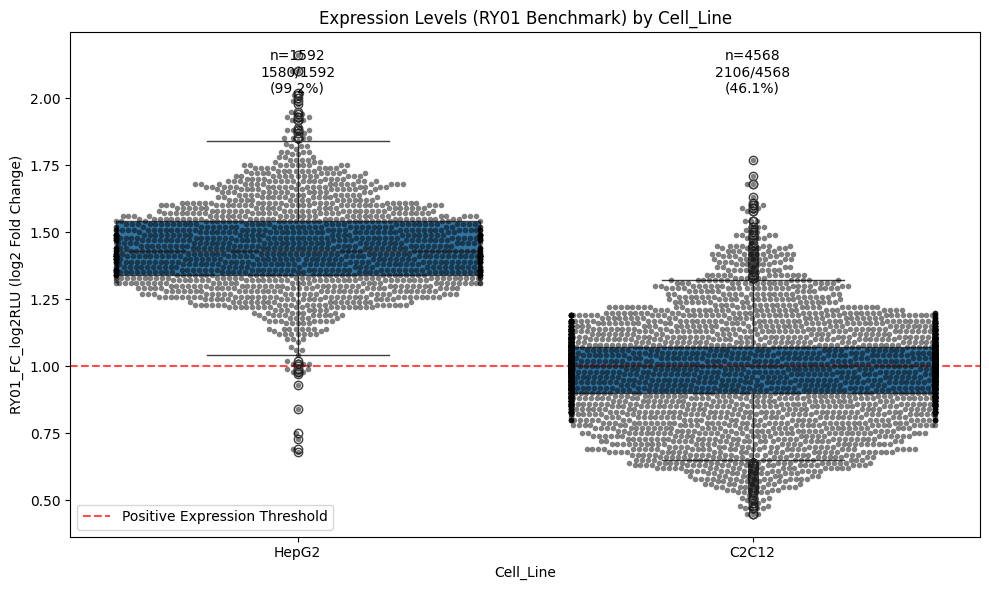

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 23.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 34.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 1500x800 with 0 Axes>

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 16.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


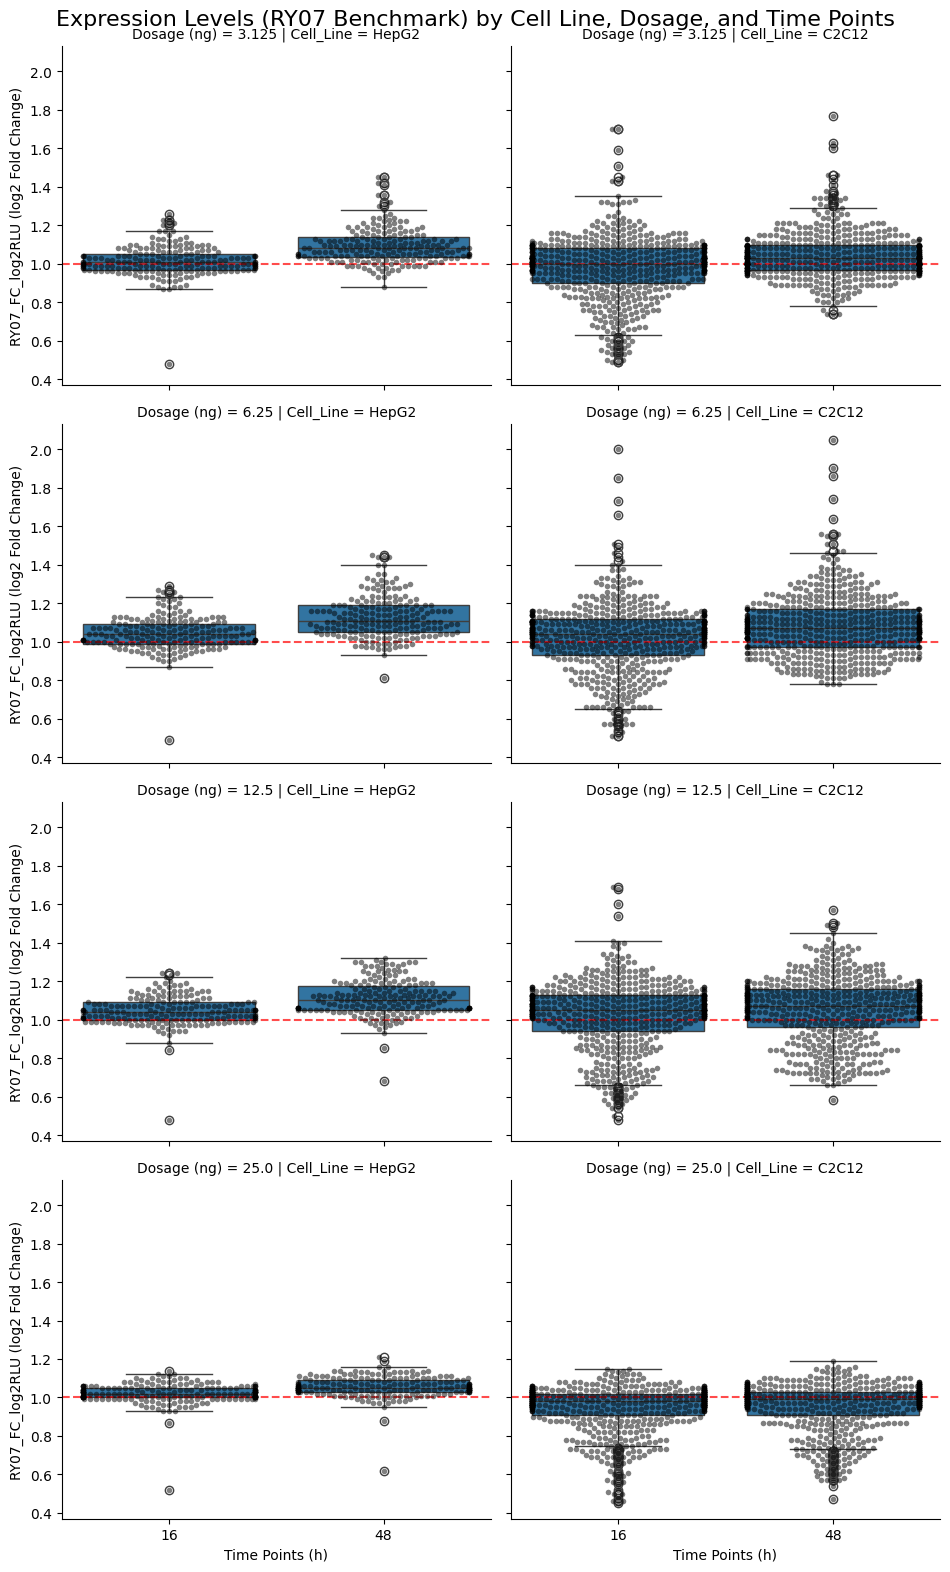

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 19.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 1500x800 with 0 Axes>

/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 19.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/yanyichu/miniconda/envs/py39_utrlm/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 23.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


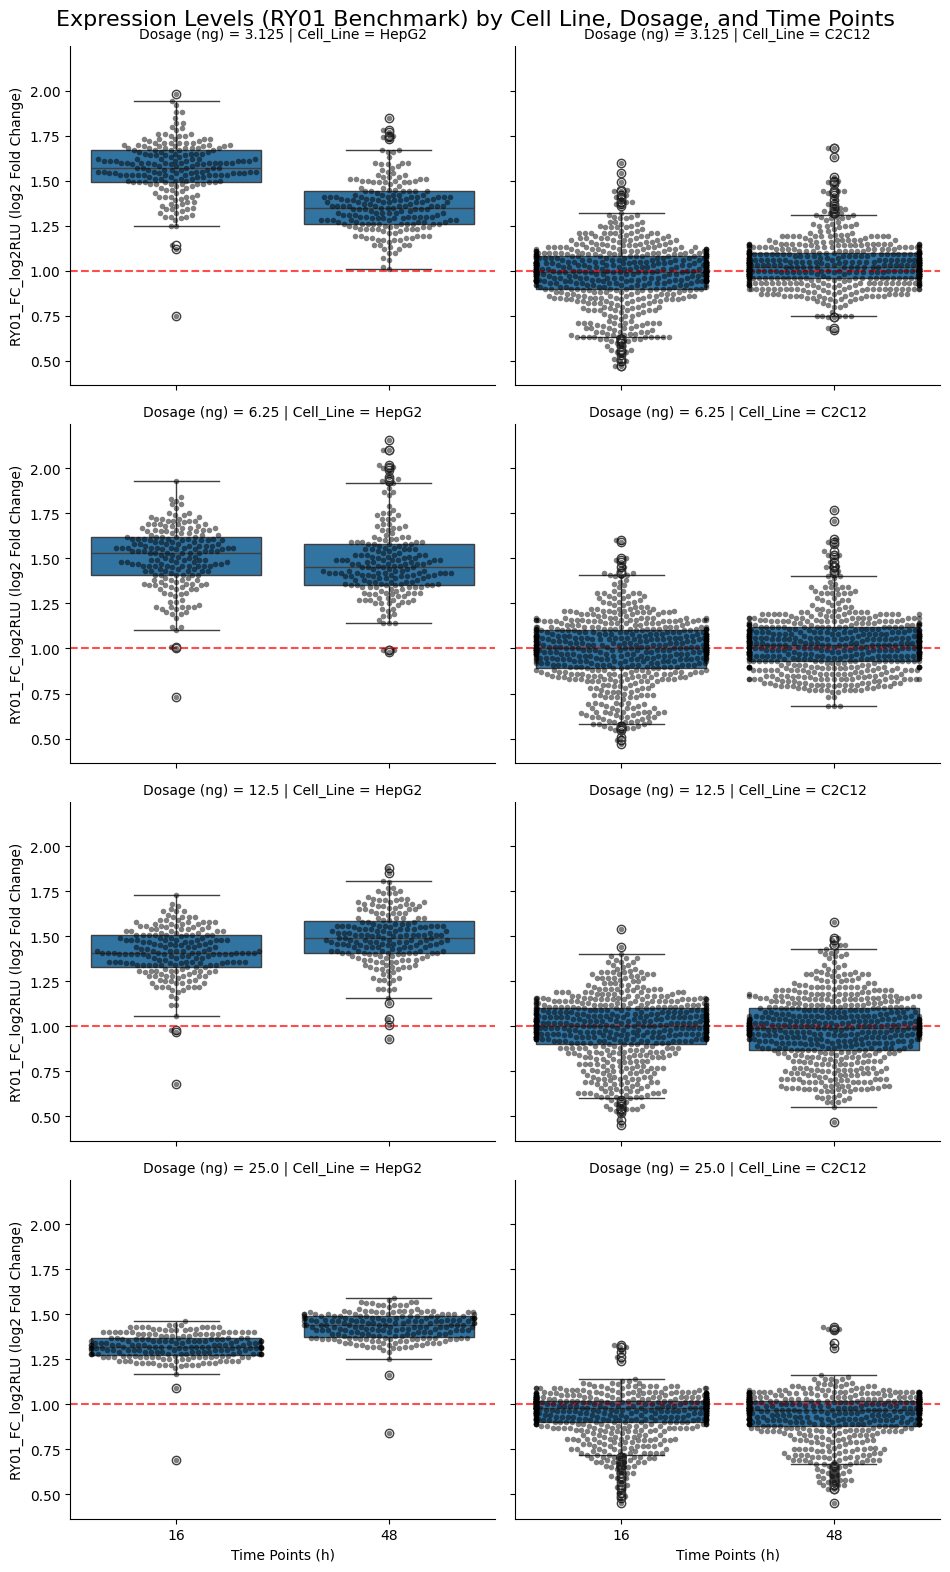

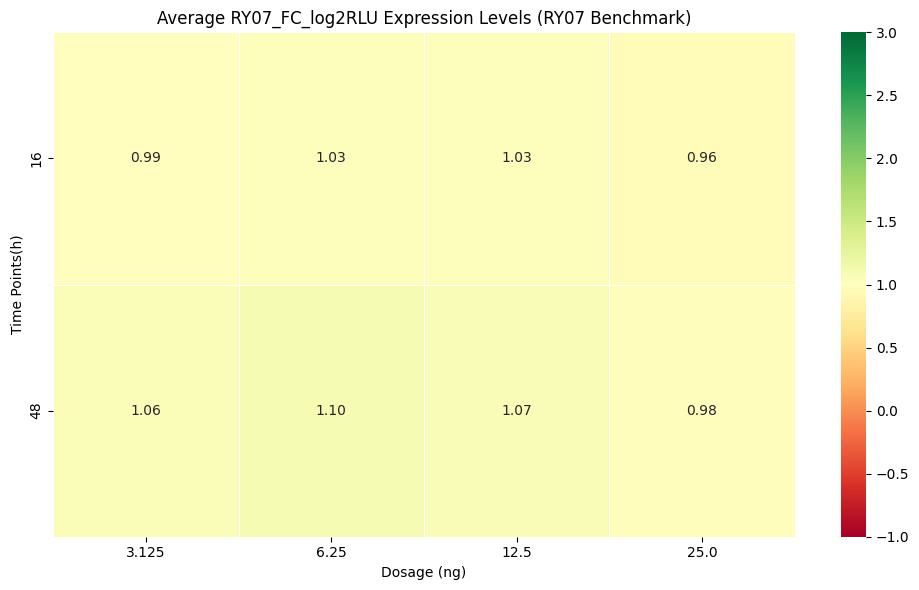

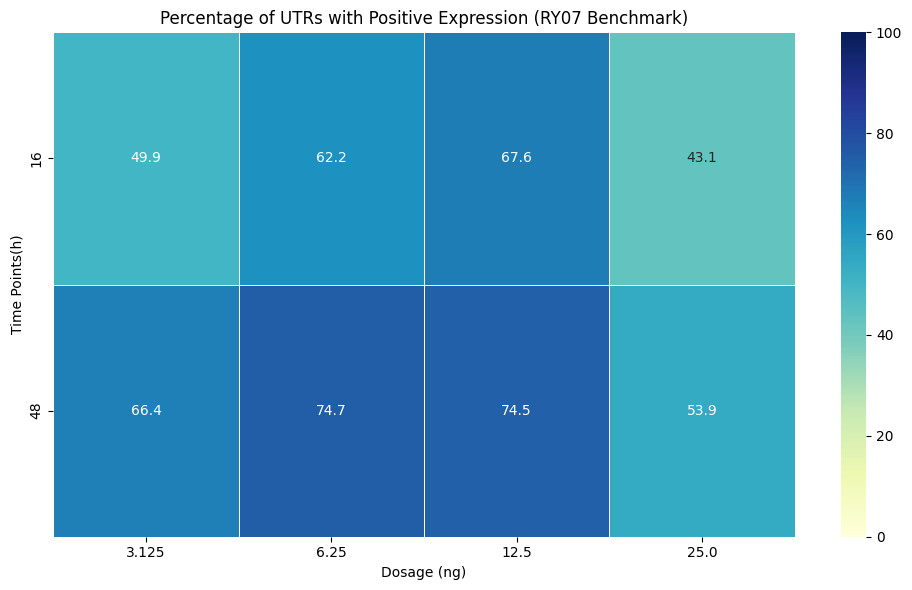

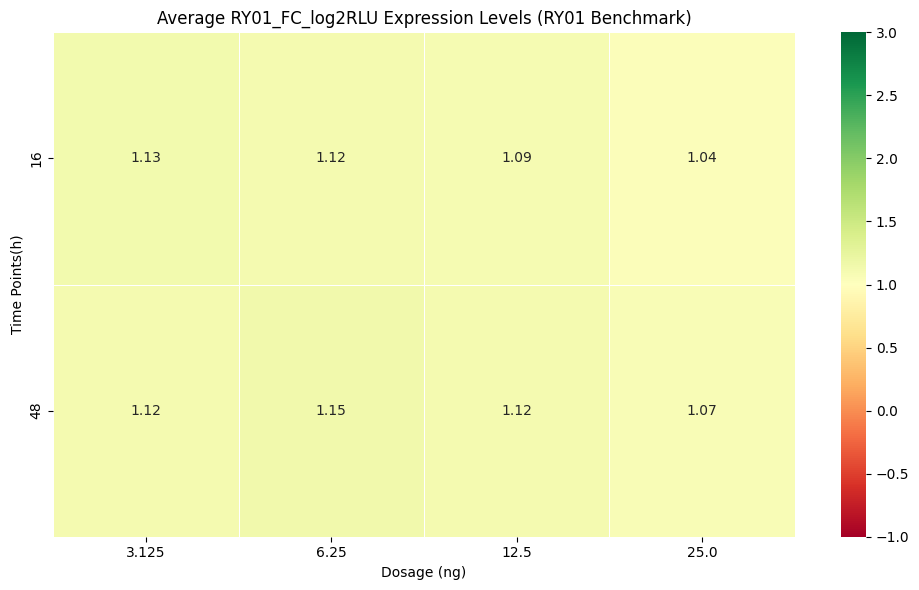

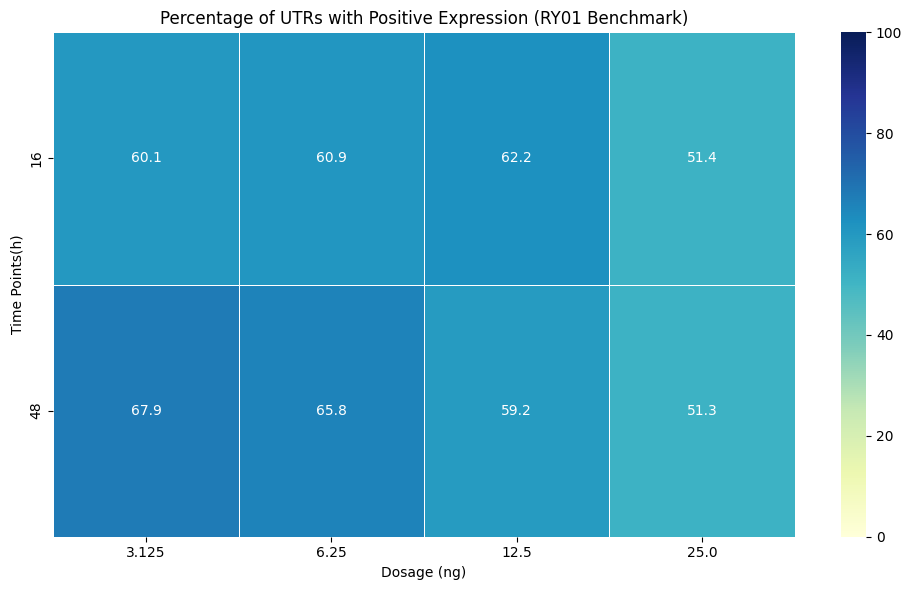

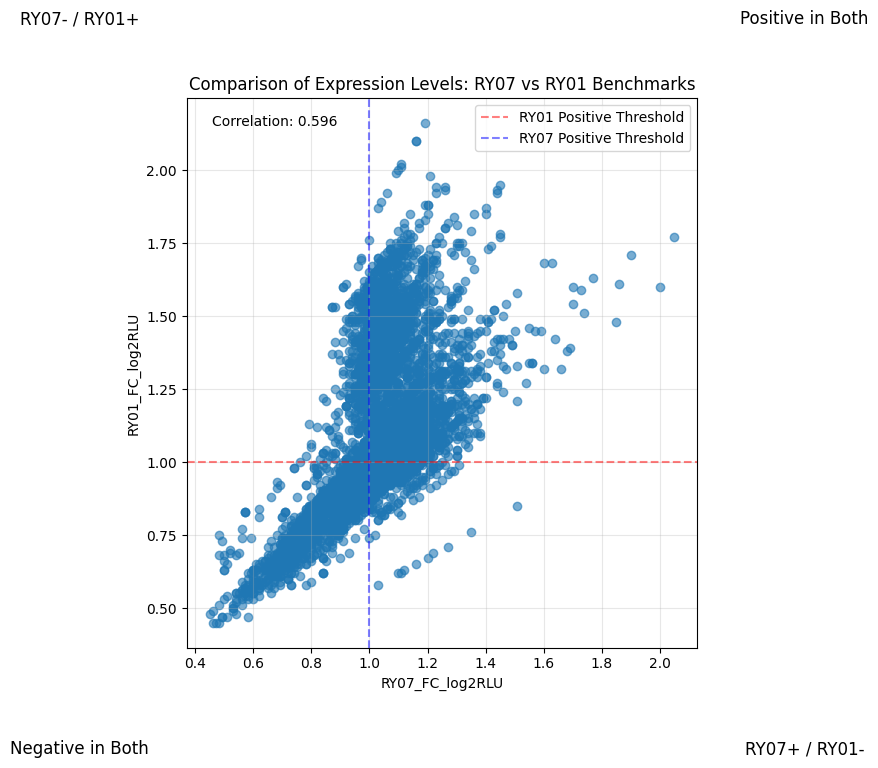

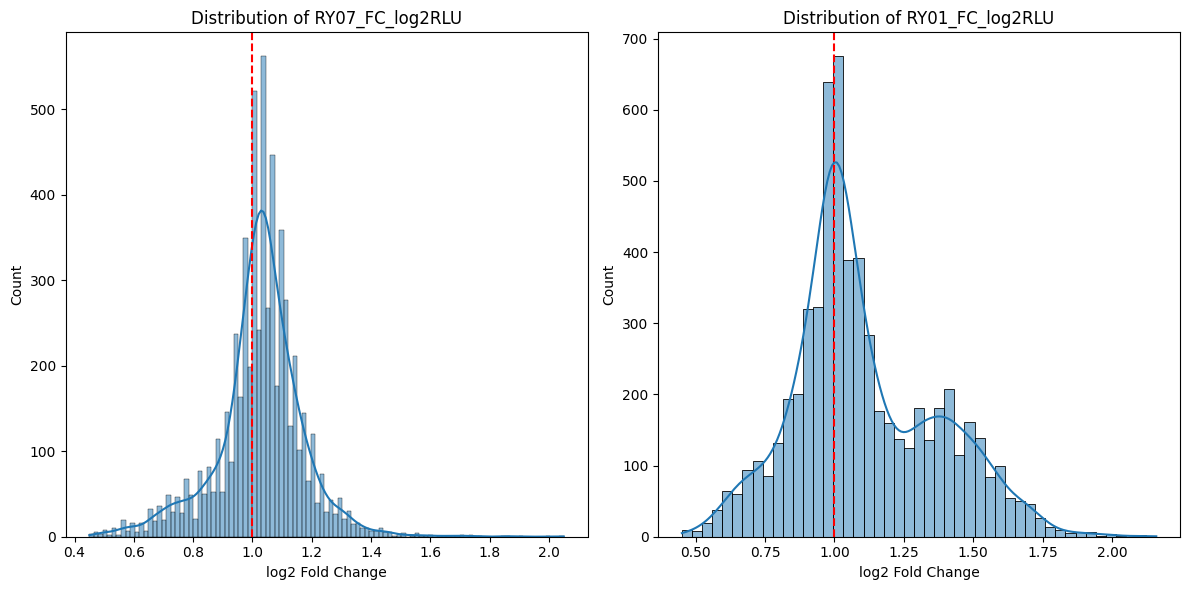

In [16]:
# Analysis by experimental conditions
# 1. Analysis by Time Points
analyze_by_condition(data, 'Time Points(h)', 'RY07_FC_log2RLU', 'RY07')
analyze_by_condition(data, 'Time Points(h)', 'RY01_FC_log2RLU', 'RY01')

# 2. Analysis by Dosage
analyze_by_condition(data, 'Dosage (ng)', 'RY07_FC_log2RLU', 'RY07')
analyze_by_condition(data, 'Dosage (ng)', 'RY01_FC_log2RLU', 'RY01')

# 3. Analysis by Cell Line
analyze_by_condition(data, 'Cell_Line', 'RY07_FC_log2RLU', 'RY07')
analyze_by_condition(data, 'Cell_Line', 'RY01_FC_log2RLU', 'RY01')
    
# 4. Combined analysis: Cell Line and Time Points
create_facet_grid(data, 'RY07_FC_log2RLU', 'RY07')
create_facet_grid(data, 'RY01_FC_log2RLU', 'RY01')

# 5. Expression heatmap - Time vs Dosage
create_heatmap(data, 'RY07_FC_log2RLU', 'RY07')
create_heatmap(data, 'RY01_FC_log2RLU', 'RY01')

# 6. Direct comparison between RY07 and RY01
compare_benchmarks(data)

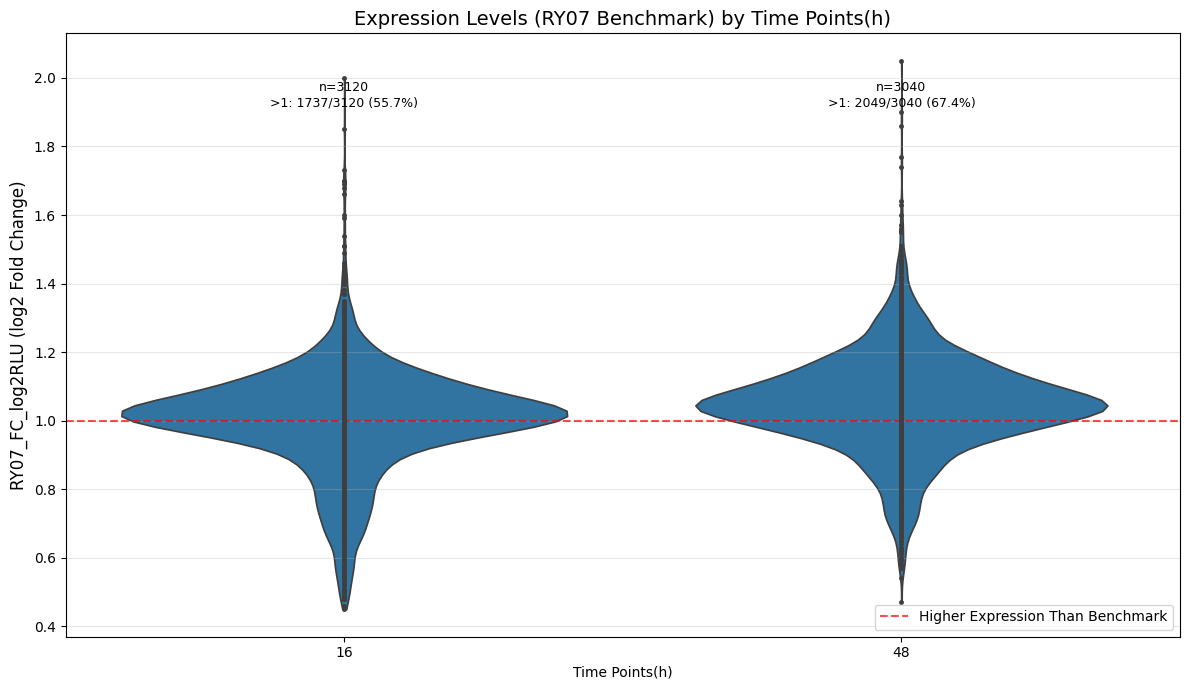

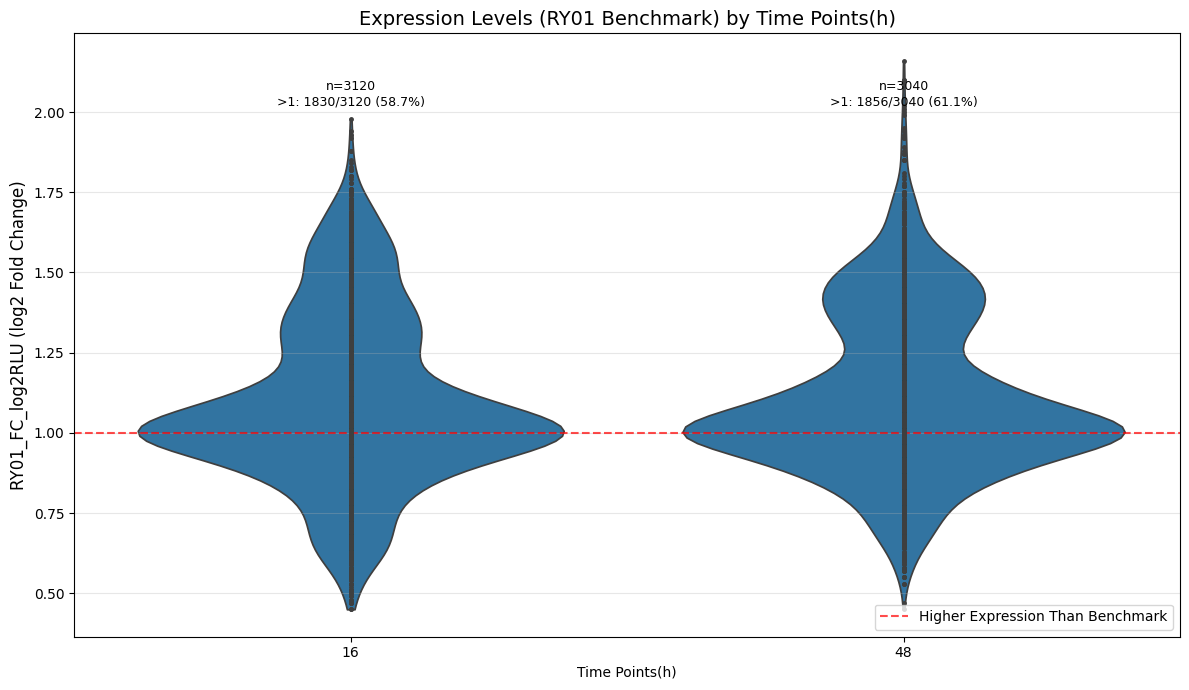

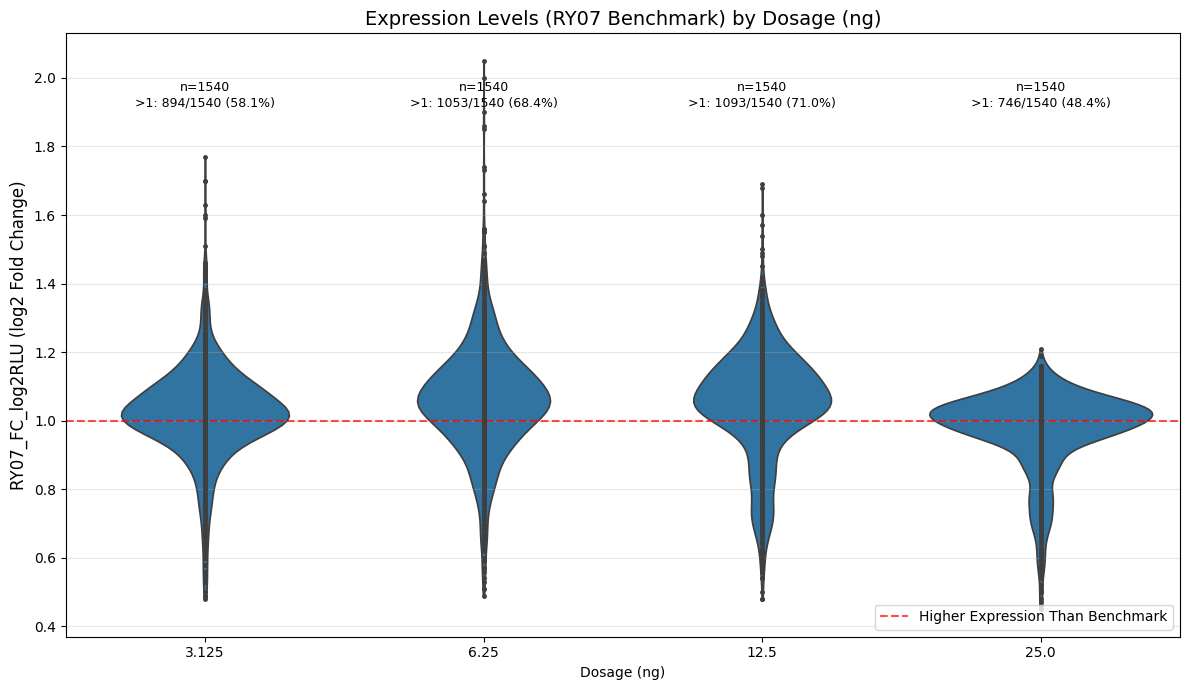

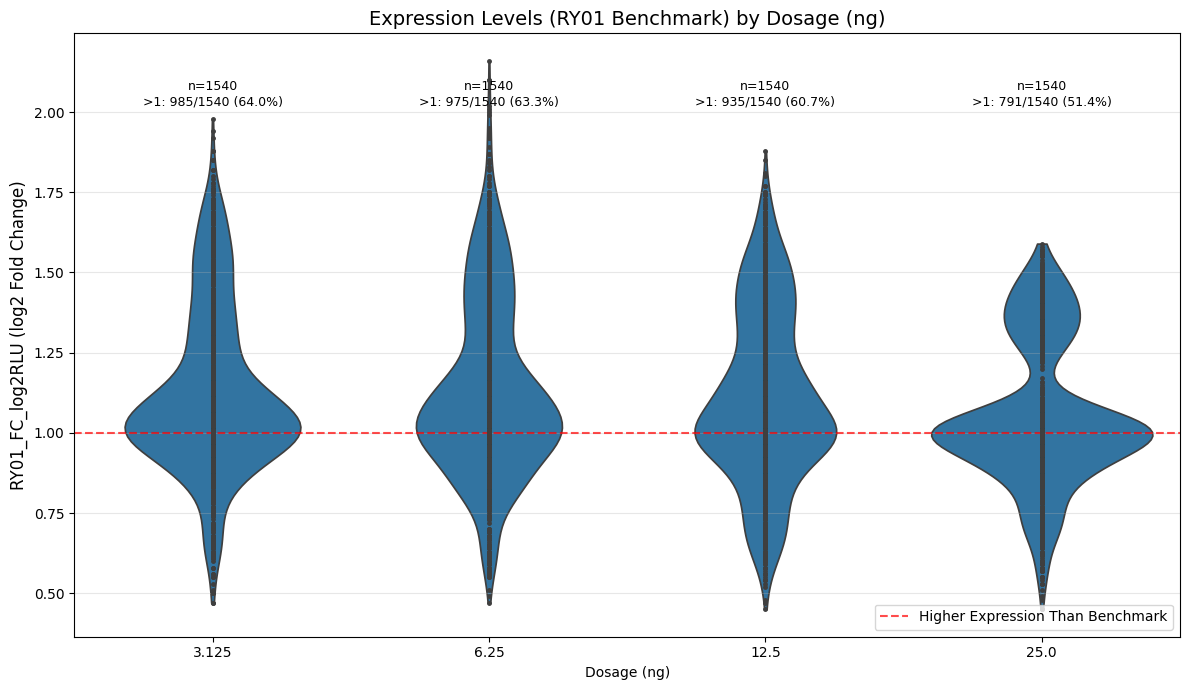

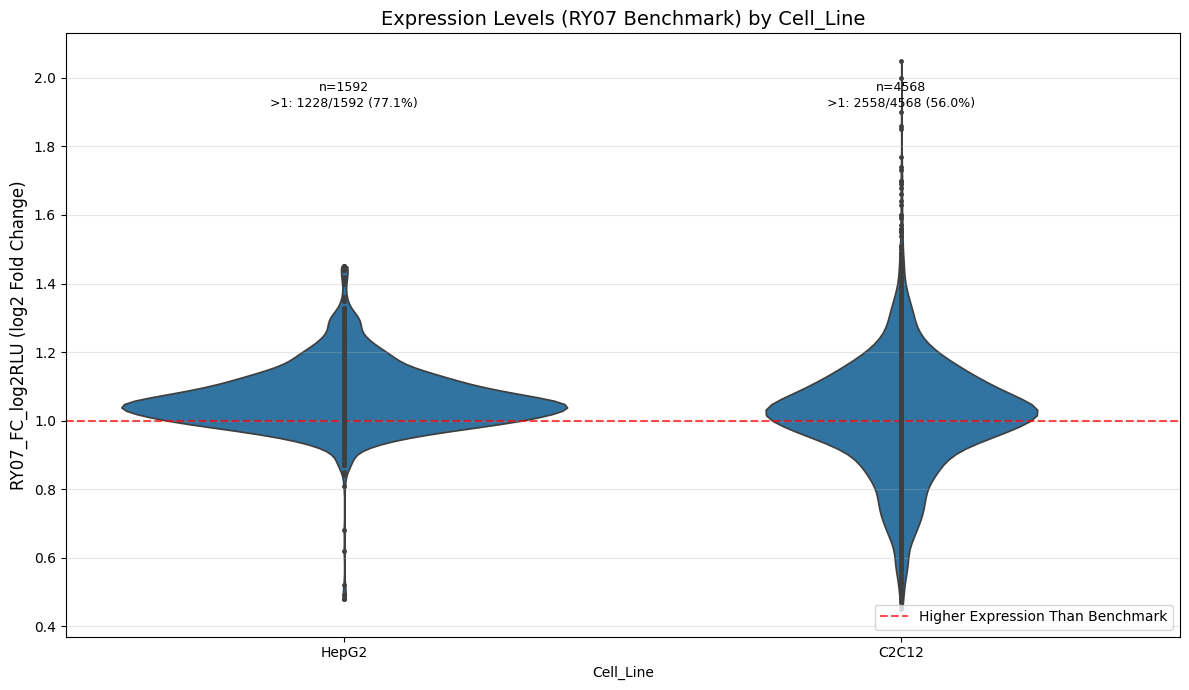

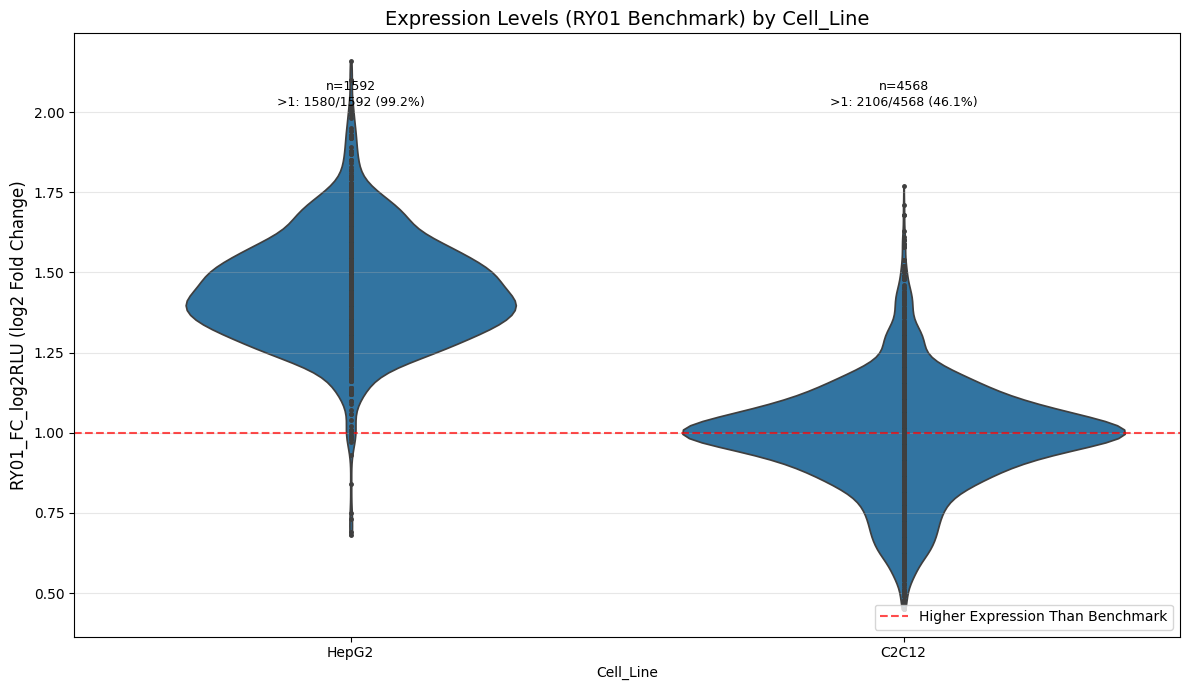

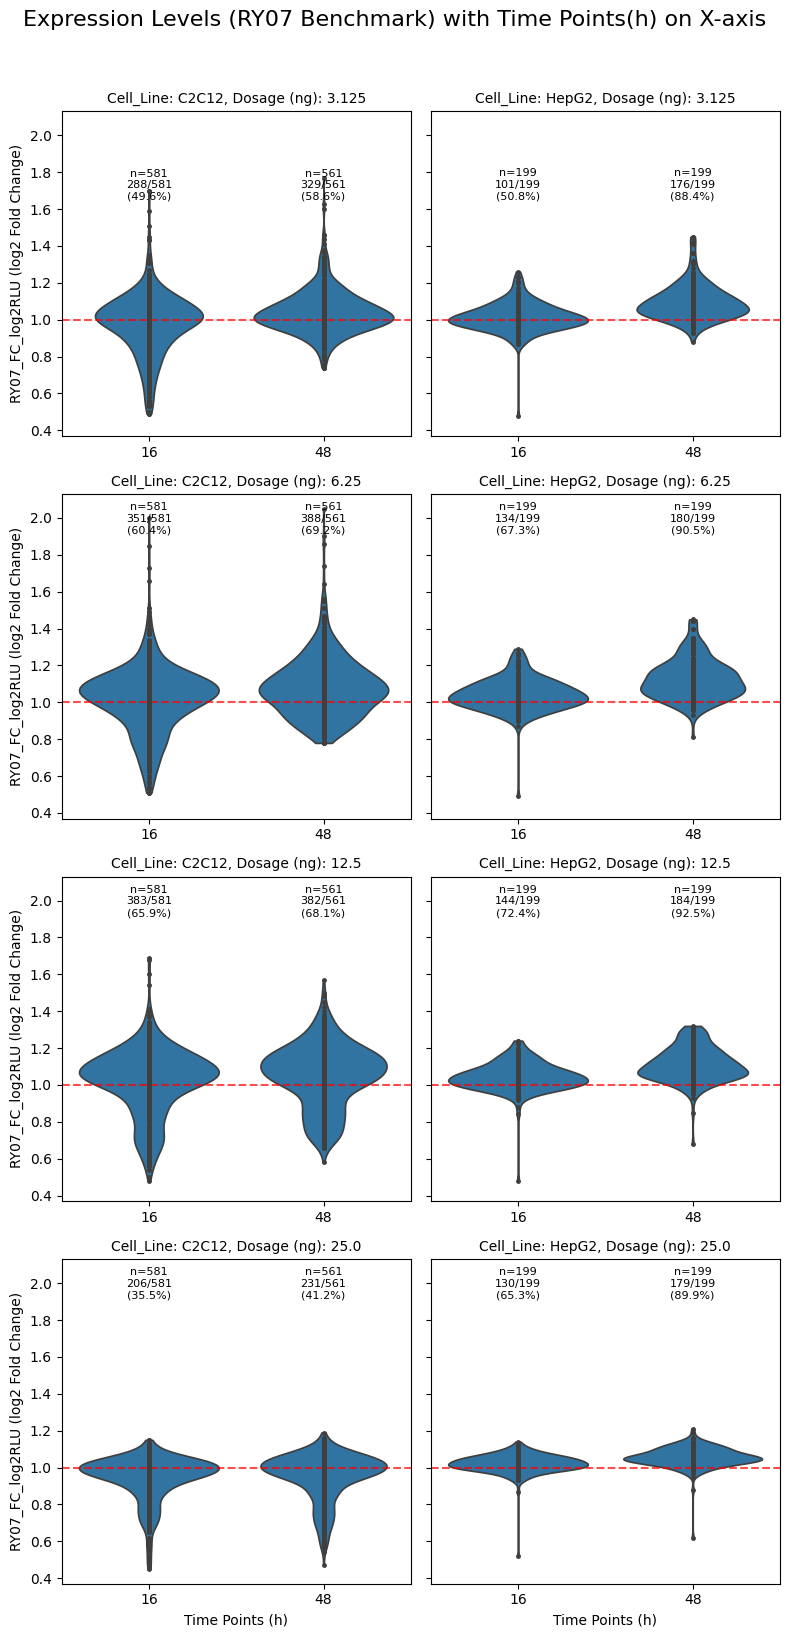

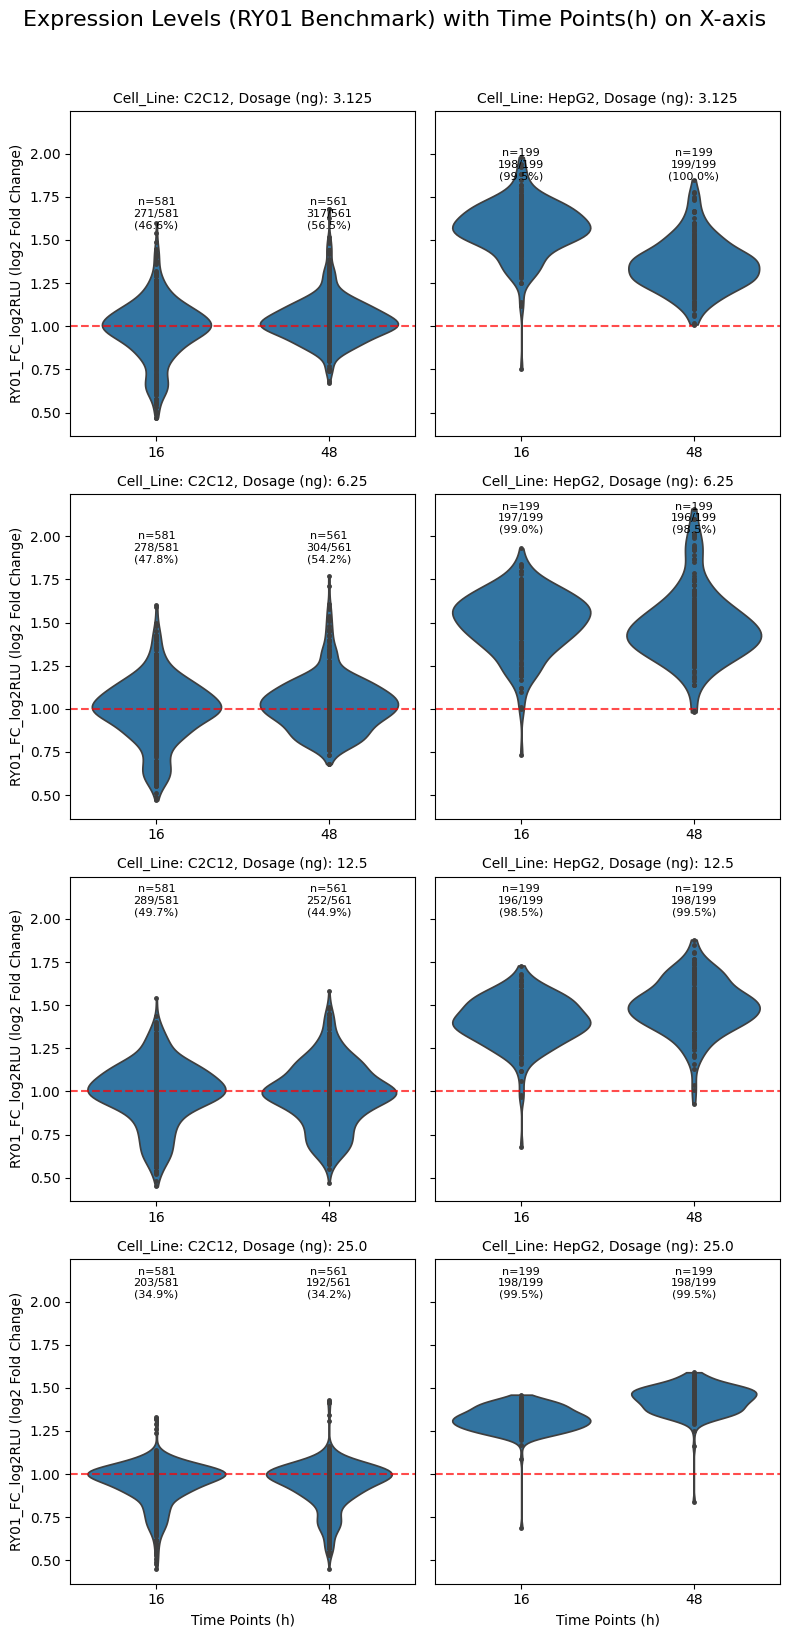

/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning

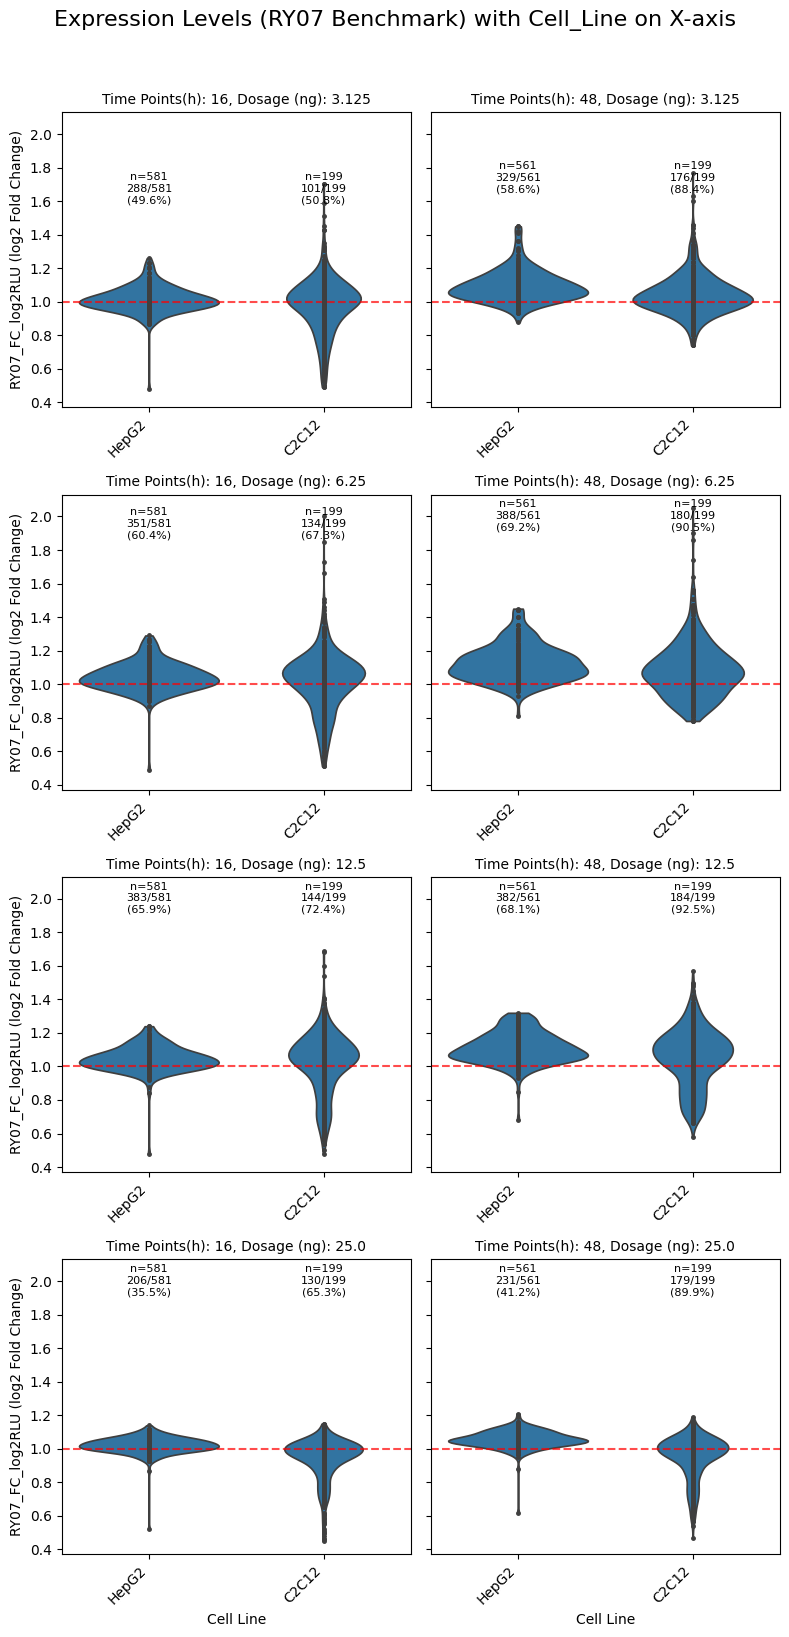

/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_360195/3630060726.py:164: UserWarning

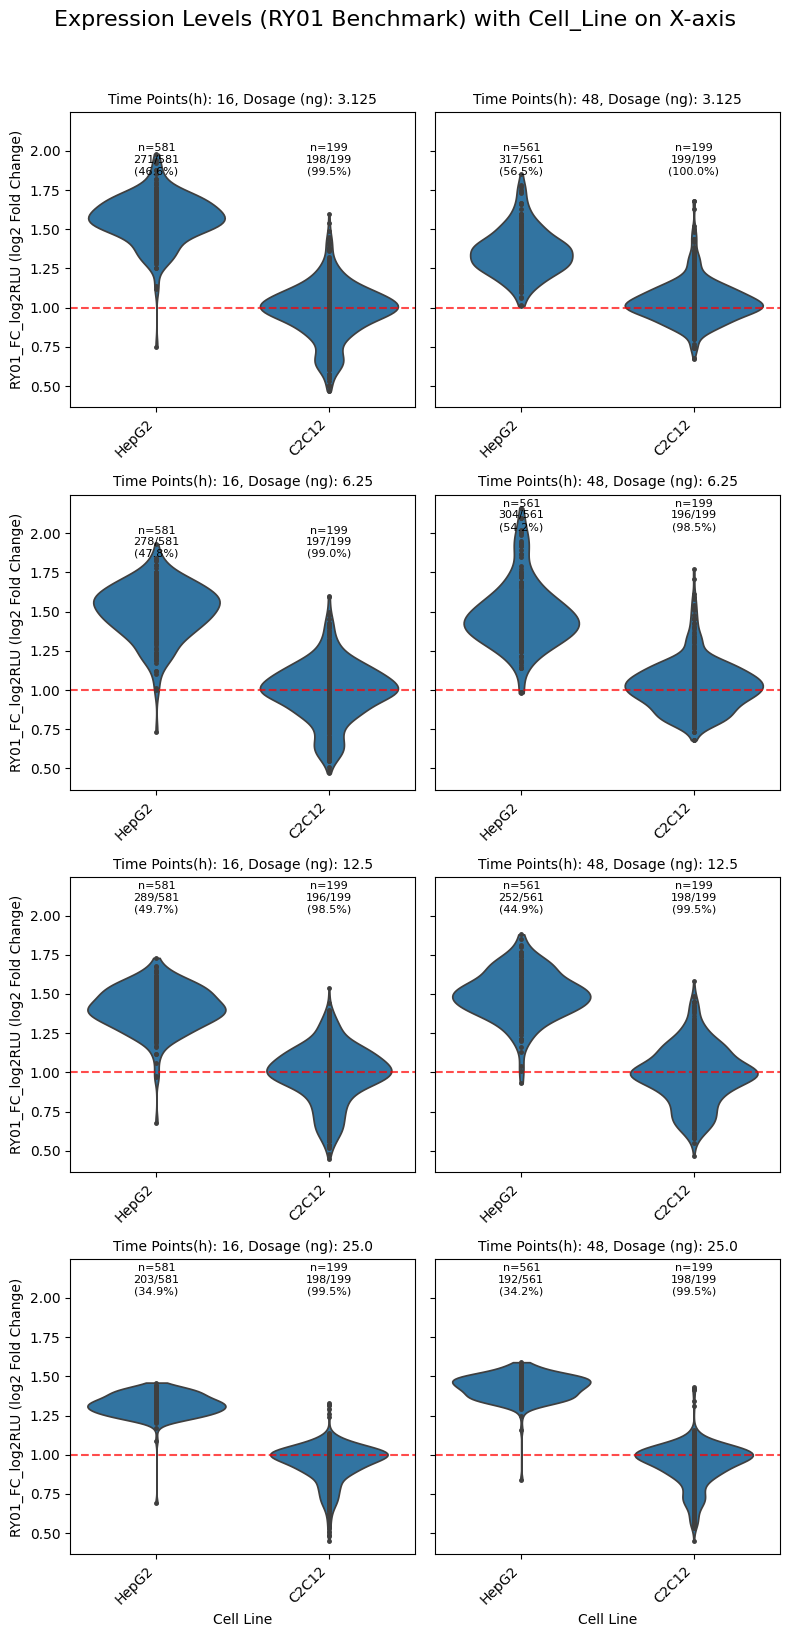

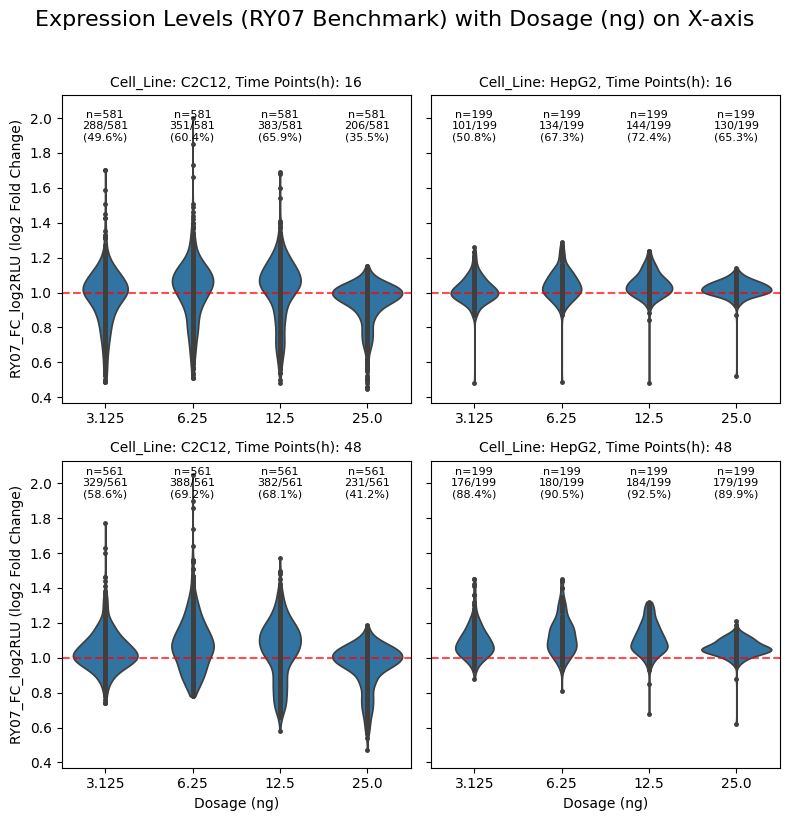

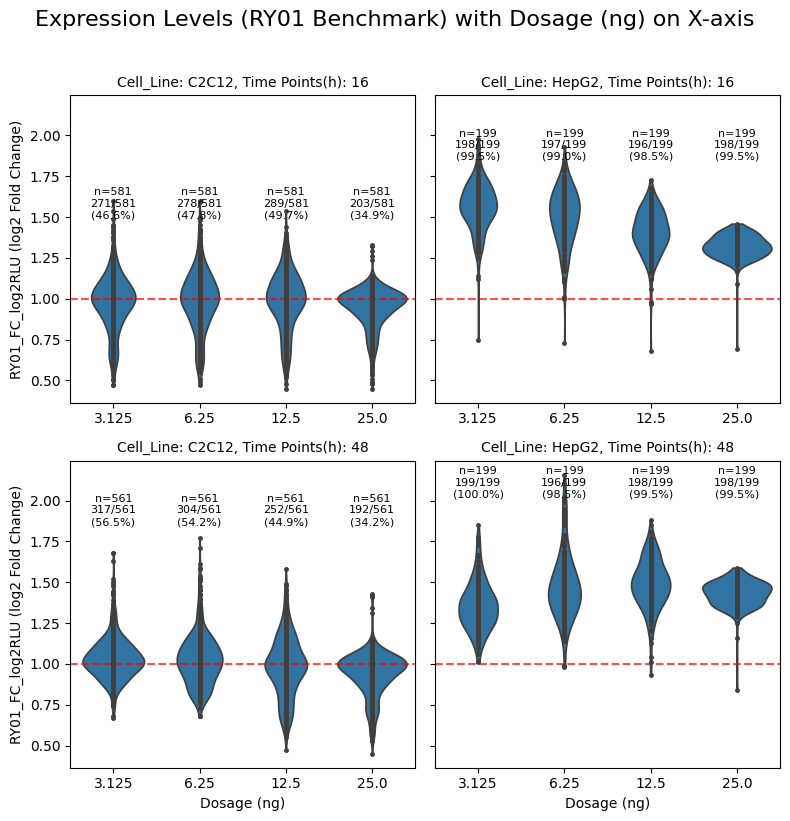

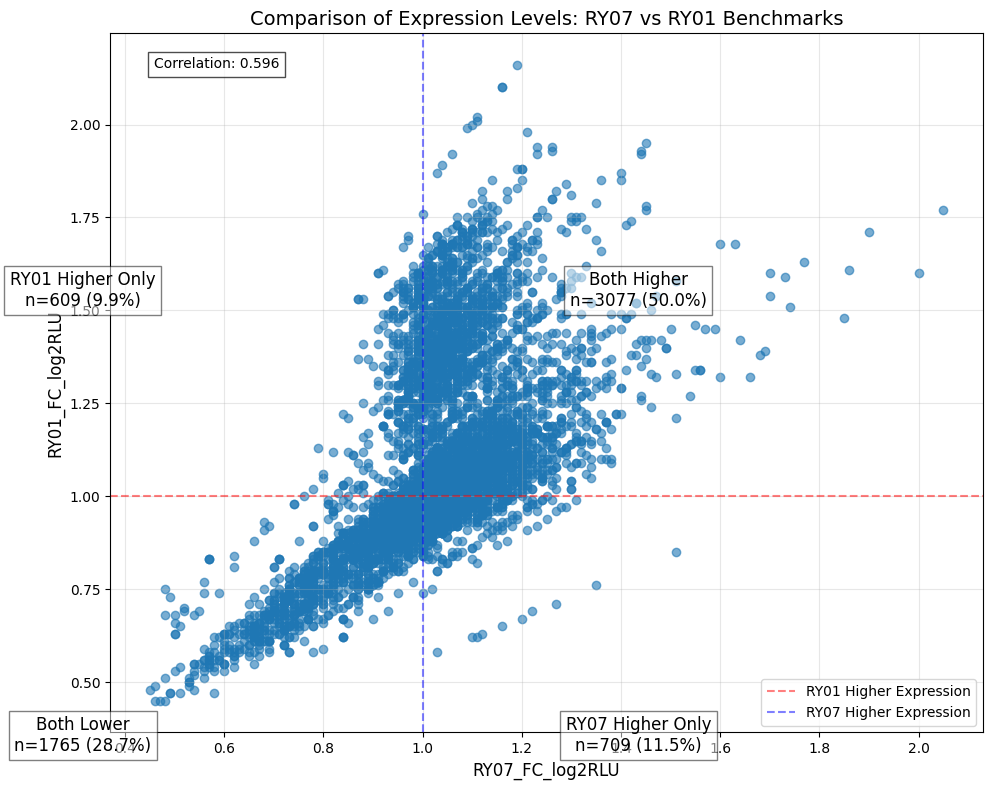

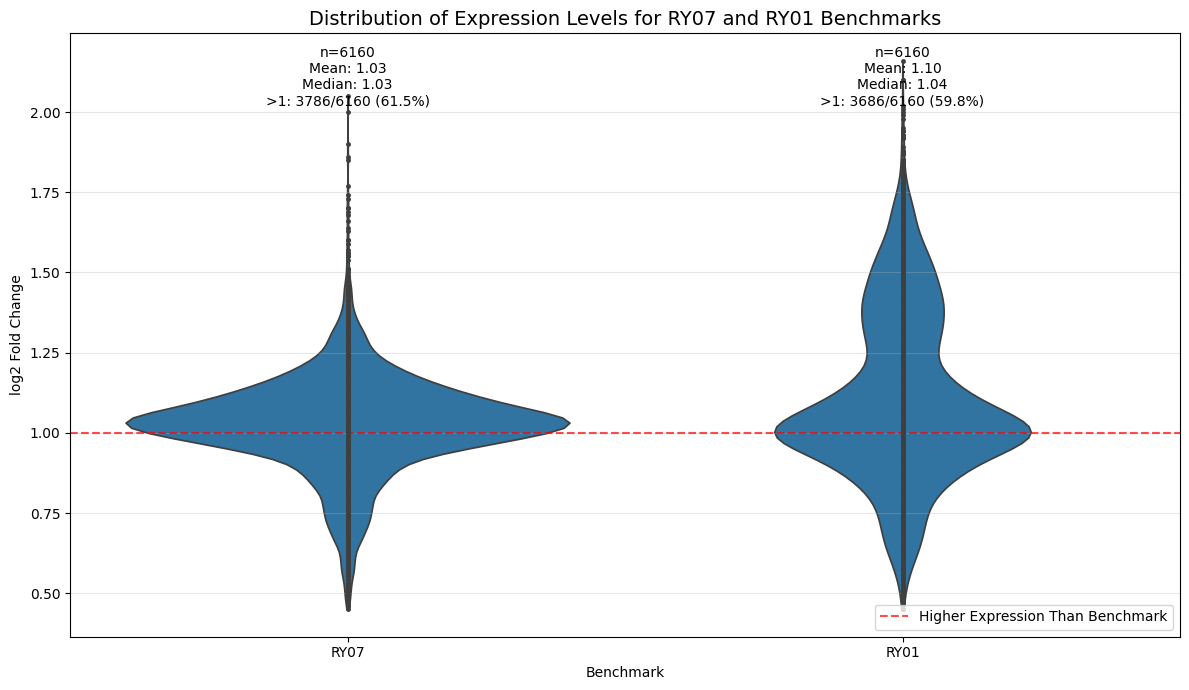

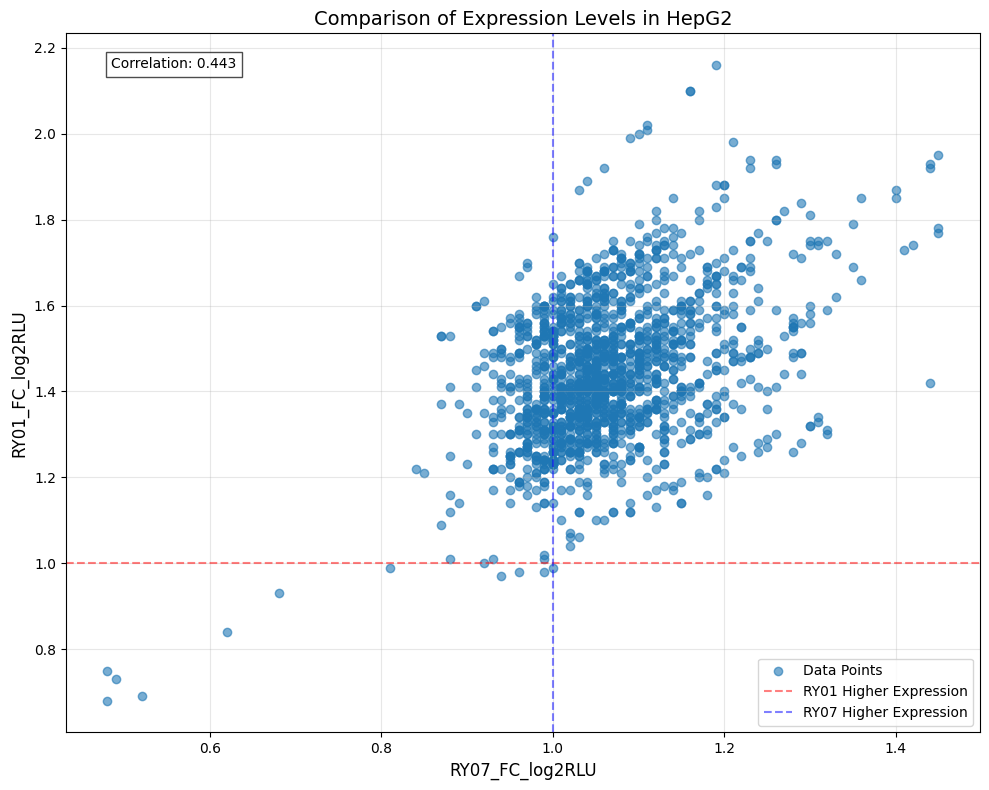

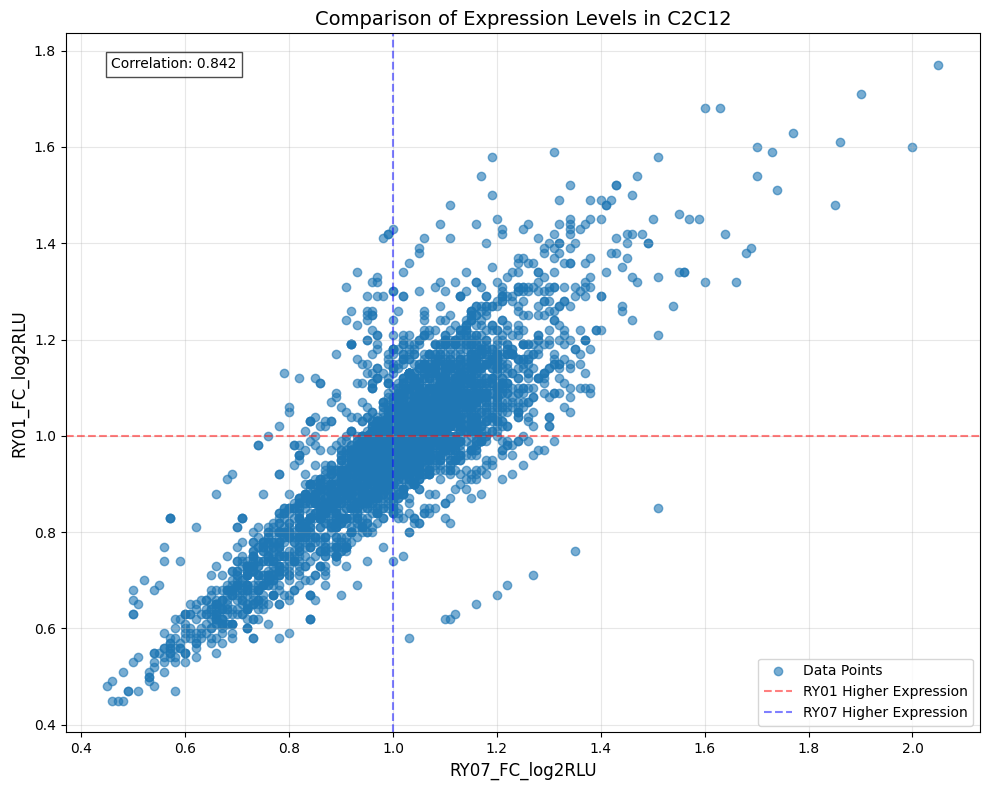

In [62]:
'''
UTR表达水平分析：条件影响与基准比较
本分析旨在全面评估不同实验条件对UTR表达水平的影响，采用了多维度的可视化方法，深入探究表达模式与条件依赖性。我们通过小提琴图展示了表达水平的分布特征，这种方法不仅能展示数据的中心趋势，还能直观呈现数据的离散程度和分布形态。
分析首先从三个基本维度入手：时间点、剂量和细胞系，分别针对RY01和RY07两个基准进行比较。在每个维度的可视化中，我们标注了样本数量和高表达序列(log2FC>1)的比例，这有助于识别哪些条件更容易诱导UTR高表达。特别值得注意的是，不同条件下高表达比例的变化反映了UTR对实验条件的敏感性。
进一步，我们构建了多维度联合分析网格，从三个不同视角(时间点、剂量、细胞系作为X轴)展示数据，这种方法能够揭示条件组合的交互效应。例如，某些UTR序列可能在特定细胞系与时间点组合下表现最佳，而在其他组合中表现平平。
最后，我们直接比较了RY01与RY07两个基准下的表达水平，散点图清晰地展示了四个象限中序列的分布情况。相关性分析表明两个基准间存在一定程度的关联，但也有相当比例的序列表现出基准特异性响应。我们还针对每个细胞系单独进行了基准比较，以捕捉细胞系特异的表达模式。
通过这种综合分析，我们能够识别出在多种条件下表现稳定的优质UTR序列，同时也发现了对特定条件高度敏感的序列。这些发现为UTR序列的选择和实验条件的优化提供了重要依据，有助于提高基因表达系统的稳定性和效率。

对每个维度（时间点、剂量、细胞系）分别进行分组
计算每个条件组中的样本总数和高表达序列数量
计算高表达比例 = 高表达序列数 / 样本总数 × 100%
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_utr_expression(data):
    # Analysis by experimental conditions
    # 1. Analysis by Time Points
    analyze_by_condition(data, 'Time Points(h)', 'RY07_FC_log2RLU', 'RY07')
    analyze_by_condition(data, 'Time Points(h)', 'RY01_FC_log2RLU', 'RY01')
    
    # 2. Analysis by Dosage
    analyze_by_condition(data, 'Dosage (ng)', 'RY07_FC_log2RLU', 'RY07')
    analyze_by_condition(data, 'Dosage (ng)', 'RY01_FC_log2RLU', 'RY01')
    
    # 3. Analysis by Cell Line
    analyze_by_condition(data, 'Cell_Line', 'RY07_FC_log2RLU', 'RY07')
    analyze_by_condition(data, 'Cell_Line', 'RY01_FC_log2RLU', 'RY01')
    
    # 4. Combined analysis with different x-axes
    # Time Points as x-axis
    create_facet_grid(data, 'RY07_FC_log2RLU', 'RY07', x_var='Time Points(h)')
    create_facet_grid(data, 'RY01_FC_log2RLU', 'RY01', x_var='Time Points(h)')
    
    # Cell Line as x-axis
    create_facet_grid(data, 'RY07_FC_log2RLU', 'RY07', x_var='Cell_Line')
    create_facet_grid(data, 'RY01_FC_log2RLU', 'RY01', x_var='Cell_Line')
    
    # Dosage as x-axis
    create_facet_grid(data, 'RY07_FC_log2RLU', 'RY07', x_var='Dosage (ng)')
    create_facet_grid(data, 'RY01_FC_log2RLU', 'RY01', x_var='Dosage (ng)')
    
    # 5. Direct comparison between RY07 and RY01
    compare_benchmarks(data)

def analyze_by_condition(data, condition, target, benchmark):
    """Analyze expression levels by a specific condition using violin plots."""
    plt.figure(figsize=(12, 7))
    
    if condition in ['Time Points(h)', 'Dosage (ng)']:
        # For numerical conditions, create violin plots
        ax = sns.violinplot(x=condition, y=target, data=data, cut=0, inner='point')
        
        # Add a horizontal line at log2FC = 1 to indicate higher expression than benchmark
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Higher Expression Than Benchmark')
        
        # Add count and percentage above each violin
        for i, level in enumerate(sorted(data[condition].unique())):
            subset = data[data[condition] == level]
            positive_count = sum(subset[target] > 1)
            percentage = positive_count / len(subset) * 100 if len(subset) > 0 else 0
            
            # Calculate the middle position of the violin
            plt.text(i, ax.get_ylim()[1] * 0.9, 
                    f"n={len(subset)}\n>{1}: {positive_count}/{len(subset)} ({percentage:.1f}%)", 
                    horizontalalignment='center', fontsize=9)
    else:
        # For categorical conditions like Cell_Line
        ax = sns.violinplot(x=condition, y=target, data=data, cut=0, inner='point')
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Higher Expression Than Benchmark')
        
        # Add count and percentage above each violin
        for i, cell in enumerate(data[condition].unique()):
            subset = data[data[condition] == cell]
            positive_count = sum(subset[target] > 1)
            percentage = positive_count / len(subset) * 100 if len(subset) > 0 else 0
            
            plt.text(i, ax.get_ylim()[1] * 0.9, 
                    f"n={len(subset)}\n>{1}: {positive_count}/{len(subset)} ({percentage:.1f}%)", 
                    horizontalalignment='center', fontsize=9)
    
    plt.title(f'Expression Levels ({benchmark} Benchmark) by {condition}', fontsize=14)
    plt.ylabel(f'{target} (log2 Fold Change)', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'./UTR_sequences/expression_{benchmark}_by_{condition.replace(" ", "_")}_violin.png', dpi=300)
    plt.show()

def create_facet_grid(data, target, benchmark, x_var='Time Points(h)'):
    """Create a facet grid to analyze expression across different variables."""
    # Get unique values for the grid layout
    if x_var == 'Time Points(h)':
        row_var = 'Dosage (ng)'
        col_var = 'Cell_Line'
        xlabel = 'Time Points (h)'
    elif x_var == 'Cell_Line':
        row_var = 'Dosage (ng)'
        col_var = 'Time Points(h)'
        xlabel = 'Cell Line'
    else:  # x_var == 'Dosage (ng)'
        row_var = 'Time Points(h)'
        col_var = 'Cell_Line'
        xlabel = 'Dosage (ng)'
    
    # Get unique values
    row_values = sorted(data[row_var].unique())
    col_values = sorted(data[col_var].unique())
    
    # Create a figure with subplots
    fig, axes = plt.subplots(len(row_values), len(col_values), 
                            figsize=(4*len(col_values), 4*len(row_values)),
                            sharex=False, sharey=True)
    
    # Make axes 2D if it's 1D
    if len(row_values) == 1:
        axes = np.array([axes])
    if len(col_values) == 1:
        axes = np.array([axes]).T
    
    # Iterate through each subplot
    for i, row_val in enumerate(row_values):
        for j, col_val in enumerate(col_values):
            ax = axes[i, j]
            
            # Filter data for this subplot
            if x_var == 'Time Points(h)':
                subplot_data = data[(data[row_var] == row_val) & (data[col_var] == col_val)]
                subplot_title = f'{col_var}: {col_val}, {row_var}: {row_val}'
            elif x_var == 'Cell_Line':
                subplot_data = data[(data[row_var] == row_val) & (data[col_var] == col_val)]
                subplot_title = f'{col_var}: {col_val}, {row_var}: {row_val}'
            else:  # x_var == 'Dosage (ng)'
                subplot_data = data[(data[row_var] == row_val) & (data[col_var] == col_val)]
                subplot_title = f'{col_var}: {col_val}, {row_var}: {row_val}'
            
            if not subplot_data.empty:
                # Create violin plot
                sns.violinplot(x=x_var, y=target, data=subplot_data, 
                              cut=0, inner='point', ax=ax)
                
                # Add reference line
                ax.axhline(y=1, color='r', linestyle='--', alpha=0.7)
                
                # Add count and percentage for each x value
                x_values = sorted(subplot_data[x_var].unique())
                for k, x_val in enumerate(x_values):
                    x_data = subplot_data[subplot_data[x_var] == x_val]
                    if len(x_data) > 0:
                        positive_count = sum(x_data[target] > 1)
                        percentage = positive_count / len(x_data) * 100
                        
                        ax.text(k, ax.get_ylim()[1] * 0.9, 
                                f"n={len(x_data)}\n{positive_count}/{len(x_data)}\n({percentage:.1f}%)", 
                                horizontalalignment='center', fontsize=8)
            
            # Set subplot title
            ax.set_title(subplot_title, fontsize=10)
            
            # Only show x label on bottom row
            if i == len(row_values) - 1:
                ax.set_xlabel(xlabel)
            else:
                ax.set_xlabel('')
            
            # Only show y label on leftmost column
            if j == 0:
                ax.set_ylabel(f'{target} (log2 Fold Change)')
            else:
                ax.set_ylabel('')
                
            # Set x-tick rotation for cell lines if needed
            if x_var == 'Cell_Line':
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Add an overall title
    fig.suptitle(f'Expression Levels ({benchmark} Benchmark) with {x_var} on X-axis', 
                fontsize=16, y=1.02)
    
    plt.tight_layout()
    plt.savefig(f'./UTR_sequences/expression_{benchmark}_by_{x_var.replace(" ", "_")}_violin.png', dpi=300)
    plt.show()

def compare_benchmarks(data):
    """Directly compare expression levels between RY07 and RY01 benchmarks."""
    plt.figure(figsize=(10, 8))
    
    # Scatter plot comparing RY07 vs RY01 expression
    plt.scatter(data['RY07_FC_log2RLU'], data['RY01_FC_log2RLU'], alpha=0.6)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='RY01 Higher Expression')
    plt.axvline(x=1, color='b', linestyle='--', alpha=0.5, label='RY07 Higher Expression')
    
    # Calculate quadrant percentages
    total = len(data)
    q1 = ((data['RY07_FC_log2RLU'] > 1) & (data['RY01_FC_log2RLU'] > 1)).sum()
    q2 = ((data['RY07_FC_log2RLU'] <= 1) & (data['RY01_FC_log2RLU'] > 1)).sum()
    q3 = ((data['RY07_FC_log2RLU'] <= 1) & (data['RY01_FC_log2RLU'] <= 1)).sum()
    q4 = ((data['RY07_FC_log2RLU'] > 1) & (data['RY01_FC_log2RLU'] <= 1)).sum()
    
    # Add quadrant labels with counts and percentages
    plt.text(data['RY07_FC_log2RLU'].max()*0.7, data['RY01_FC_log2RLU'].max()*0.7, 
             f'Both Higher\nn={q1} ({q1/total*100:.1f}%)', 
             fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.text(data['RY07_FC_log2RLU'].max()*0.7, data['RY01_FC_log2RLU'].min()*0.7, 
             f'RY07 Higher Only\nn={q4} ({q4/total*100:.1f}%)', 
             fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.text(data['RY07_FC_log2RLU'].min()*0.7, data['RY01_FC_log2RLU'].max()*0.7, 
             f'RY01 Higher Only\nn={q2} ({q2/total*100:.1f}%)', 
             fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5))
    
    plt.text(data['RY07_FC_log2RLU'].min()*0.7, data['RY01_FC_log2RLU'].min()*0.7, 
             f'Both Lower\nn={q3} ({q3/total*100:.1f}%)', 
             fontsize=12, ha='center', bbox=dict(facecolor='white', alpha=0.5))
    
    # Calculate correlation
    correlation = data['RY07_FC_log2RLU'].corr(data['RY01_FC_log2RLU'])
    plt.annotate(f'Correlation: {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                bbox=dict(facecolor='white', alpha=0.7))
    
    plt.xlabel('RY07_FC_log2RLU', fontsize=12)
    plt.ylabel('RY01_FC_log2RLU', fontsize=12)
    plt.title('Comparison of Expression Levels: RY07 vs RY01 Benchmarks', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('./UTR_sequences/benchmark_comparison.png', dpi=300)
    plt.show()
    
    # Additional analysis: Expression level distributions with violin plots
    plt.figure(figsize=(12, 7))
    
    # Create a temporary dataframe for violin plotting
    temp_df = pd.DataFrame({
        'log2 Fold Change': pd.concat([data['RY07_FC_log2RLU'], data['RY01_FC_log2RLU']]),
        'Benchmark': ['RY07'] * len(data) + ['RY01'] * len(data)
    })
    
    # Create violin plots for both benchmarks
    ax = sns.violinplot(x='Benchmark', y='log2 Fold Change', data=temp_df, cut=0, inner='point')
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Higher Expression Than Benchmark')
    
    # Add statistics annotations
    for i, benchmark in enumerate(['RY07', 'RY01']):
        if benchmark == 'RY07':
            values = data['RY07_FC_log2RLU']
            positive = data['RY07_positive'].sum()
        else:
            values = data['RY01_FC_log2RLU']
            positive = data['RY01_positive'].sum()
            
        mean_val = values.mean()
        median_val = values.median()
        
        plt.text(i, ax.get_ylim()[1] * 0.9, 
                f"n={len(values)}\nMean: {mean_val:.2f}\nMedian: {median_val:.2f}\n>{1}: {positive}/{len(values)} ({positive/len(values)*100:.1f}%)", 
                horizontalalignment='center', fontsize=10)
    
    plt.title('Distribution of Expression Levels for RY07 and RY01 Benchmarks', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('./UTR_sequences/expression_distributions_violin.png', dpi=300)
    plt.show()
    
    # Add cell-line specific benchmark comparison
    for cell_line in data['Cell_Line'].unique():
        cell_data = data[data['Cell_Line'] == cell_line]
        
        plt.figure(figsize=(10, 8))
        plt.scatter(cell_data['RY07_FC_log2RLU'], cell_data['RY01_FC_log2RLU'], alpha=0.6)
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)
        plt.axvline(x=1, color='b', linestyle='--', alpha=0.5)
        
        # Calculate correlation for this cell line
        cell_corr = cell_data['RY07_FC_log2RLU'].corr(cell_data['RY01_FC_log2RLU'])
        plt.annotate(f'Correlation: {cell_corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(facecolor='white', alpha=0.7))
        
        plt.xlabel('RY07_FC_log2RLU', fontsize=12)
        plt.ylabel('RY01_FC_log2RLU', fontsize=12)
        plt.title(f'Comparison of Expression Levels in {cell_line}', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(['Data Points', 'RY01 Higher Expression', 'RY07 Higher Expression'], loc='lower right')
        plt.tight_layout()
        plt.savefig(f'./UTR_sequences/benchmark_comparison_{cell_line}.png', dpi=300)
        plt.show()

# Usage example
# data = pd.read_csv('~/UTR_yd/UTR_sequences/vMay14_luciferase_screening_summary_log2.csv', index_col=0)
analyze_utr_expression(data)

生成核心维度热图分析...
找到 3077 个在RY01和RY07中都高表达的序列


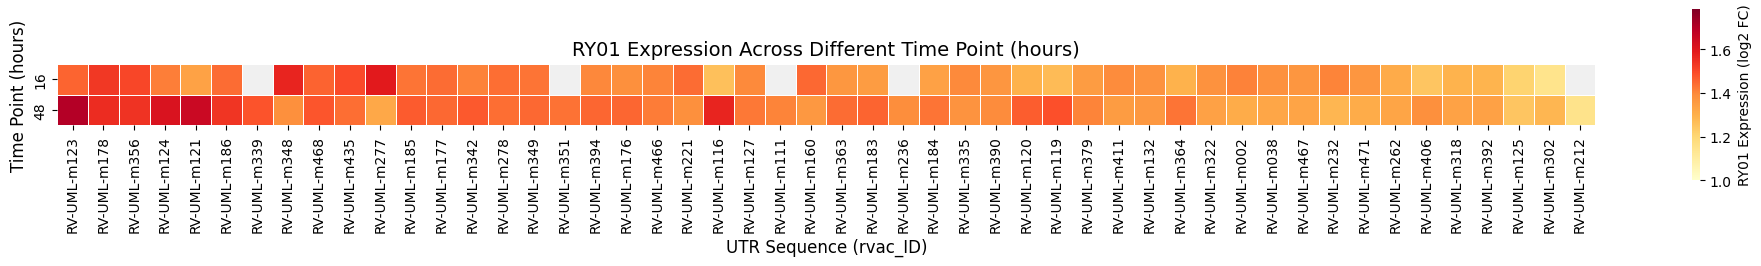

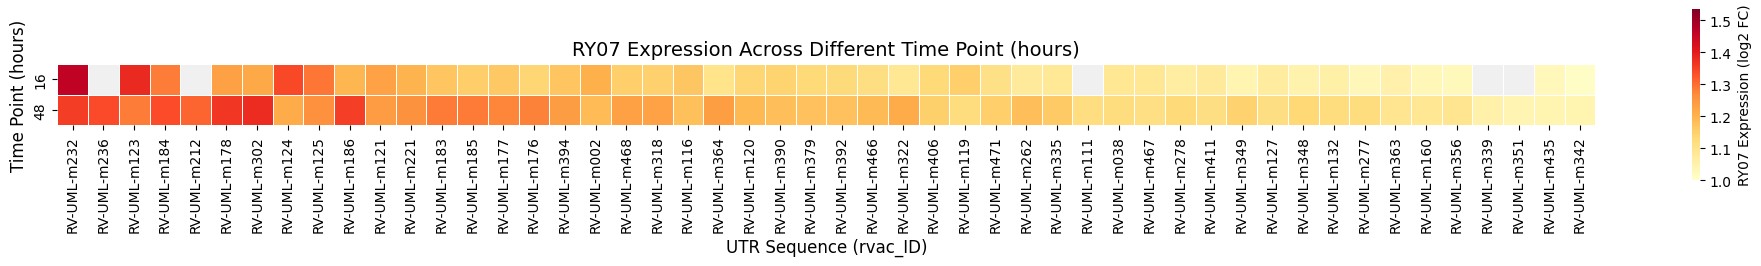

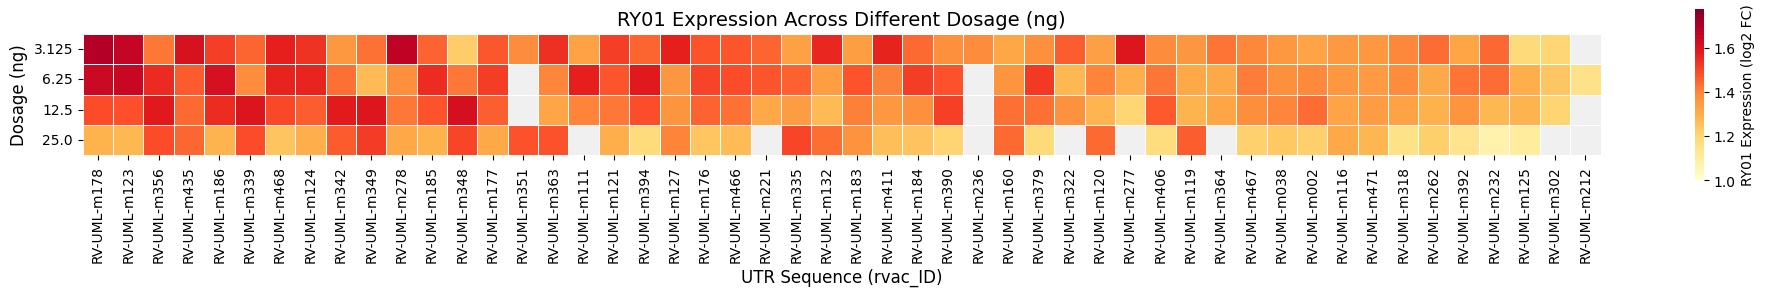

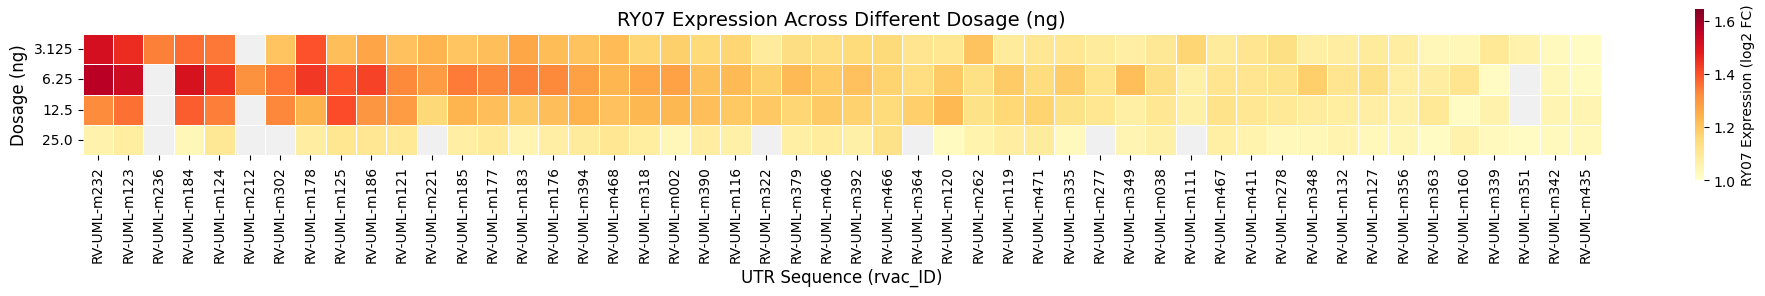

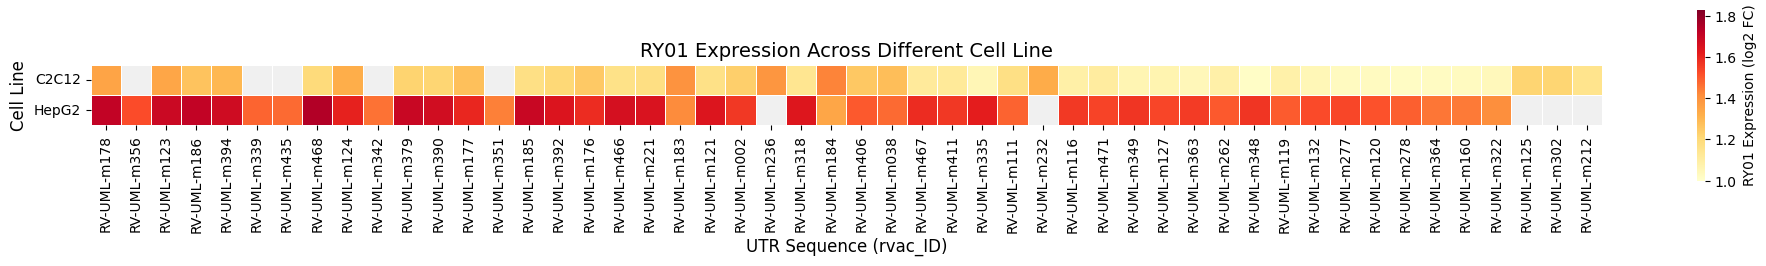

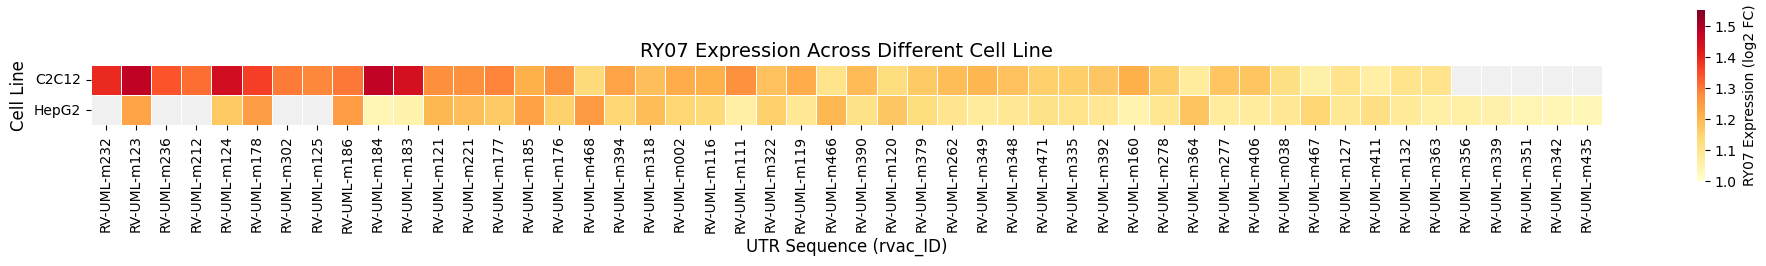

热图分析完成！


In [59]:
'''
UTR表达水平热图分析方法
这些热图是为了分析不同实验条件下UTR序列的表达水平而设计的，主要针对RY01和RY07两个基准进行分析。数据处理和可视化方法如下：
数据处理流程

数据筛选：

首先筛选出RY01和RY07表达水平都大于1的序列（both_high）
这些是相对于基准有更高表达水平的UTR序列


序列优先级排序：

计算每个序列在RY01和RY07两个基准下的平均表达值
取表现最好的前50个序列进行分析，确保热图聚焦于最有价值的序列


数据透视与转换：

对每个维度（时间点、剂量、细胞系）创建透视表
将维度作为行索引，序列ID作为列索引
数值为对应条件下的表达水平（log2FC）


数据验证与清洗：

确保每个维度条件下至少有2个序列有数据
按平均表达值对序列（列）进行降序排序
限制显示的序列数量，保持图表可读性
对缺失值进行特殊处理，使用掩码确保不显示缺失数据
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_core_dimension_heatmaps(data):
    """
    为每个关键维度创建热图，分别展示RY01和RY07的表现
    data: 包含UTR表达数据的DataFrame
    """
    print("生成核心维度热图分析...")
    
    # 筛选出RY01和RY07都>1的序列
    both_high = data[(data['RY01_FC_log2RLU'] > 1) & (data['RY07_FC_log2RLU'] > 1)]
    print(f"找到 {len(both_high)} 个在RY01和RY07中都高表达的序列")
    
    # 获取条件
    time_points = sorted(both_high['Time Points(h)'].unique())
    dosages = sorted(both_high['Dosage (ng)'].unique())
    cell_lines = sorted(both_high['Cell_Line'].unique())
    
    # 限制序列数量 - 取表现最好的序列
    seq_performance = both_high.groupby('rvac_ID')[['RY01_FC_log2RLU', 'RY07_FC_log2RLU']].mean()
    seq_performance['avg'] = (seq_performance['RY01_FC_log2RLU'] + seq_performance['RY07_FC_log2RLU']) / 2
    top_sequences = seq_performance.sort_values('avg', ascending=False).head(50).index.tolist()
    
    filtered_data = both_high[both_high['rvac_ID'].isin(top_sequences)]
    
    # 1. 时间点维度热图
    create_dimension_heatmaps(filtered_data, 'Time Points(h)', 'RY01_FC_log2RLU', 'RY01', 'Time Point (hours)')
    create_dimension_heatmaps(filtered_data, 'Time Points(h)', 'RY07_FC_log2RLU', 'RY07', 'Time Point (hours)')
    
    # 2. 剂量维度热图
    create_dimension_heatmaps(filtered_data, 'Dosage (ng)', 'RY01_FC_log2RLU', 'RY01', 'Dosage (ng)')
    create_dimension_heatmaps(filtered_data, 'Dosage (ng)', 'RY07_FC_log2RLU', 'RY07', 'Dosage (ng)')
    
    # 3. 细胞系维度热图
    create_dimension_heatmaps(filtered_data, 'Cell_Line', 'RY01_FC_log2RLU', 'RY01', 'Cell Line')
    create_dimension_heatmaps(filtered_data, 'Cell_Line', 'RY07_FC_log2RLU', 'RY07', 'Cell Line')
    
    # 保存各维度下的表现排名
    dimension_rankings = []
    
    # 时间点维度排名
    for time in time_points:
        time_data = filtered_data[filtered_data['Time Points(h)'] == time]
        ry01_avg = time_data.groupby('rvac_ID')['RY01_FC_log2RLU'].mean().sort_values(ascending=False)
        ry07_avg = time_data.groupby('rvac_ID')['RY07_FC_log2RLU'].mean().sort_values(ascending=False)
        
        for i, (seq, val) in enumerate(ry01_avg.head(10).items()):
            dimension_rankings.append({
                'Dimension': 'Time Points(h)',
                'Value': time,
                'Benchmark': 'RY01',
                'rvac_ID': seq,
                'Rank': i+1,
                'Expression': val
            })
            
        for i, (seq, val) in enumerate(ry07_avg.head(10).items()):
            dimension_rankings.append({
                'Dimension': 'Time Points(h)',
                'Value': time,
                'Benchmark': 'RY07',
                'rvac_ID': seq,
                'Rank': i+1,
                'Expression': val
            })
    
    # 剂量维度排名
    for dosage in dosages:
        dosage_data = filtered_data[filtered_data['Dosage (ng)'] == dosage]
        ry01_avg = dosage_data.groupby('rvac_ID')['RY01_FC_log2RLU'].mean().sort_values(ascending=False)
        ry07_avg = dosage_data.groupby('rvac_ID')['RY07_FC_log2RLU'].mean().sort_values(ascending=False)
        
        for i, (seq, val) in enumerate(ry01_avg.head(10).items()):
            dimension_rankings.append({
                'Dimension': 'Dosage (ng)',
                'Value': dosage,
                'Benchmark': 'RY01',
                'rvac_ID': seq,
                'Rank': i+1,
                'Expression': val
            })
            
        for i, (seq, val) in enumerate(ry07_avg.head(10).items()):
            dimension_rankings.append({
                'Dimension': 'Dosage (ng)',
                'Value': dosage,
                'Benchmark': 'RY07',
                'rvac_ID': seq,
                'Rank': i+1,
                'Expression': val
            })
    
    # 细胞系维度排名
    for cell in cell_lines:
        cell_data = filtered_data[filtered_data['Cell_Line'] == cell]
        ry01_avg = cell_data.groupby('rvac_ID')['RY01_FC_log2RLU'].mean().sort_values(ascending=False)
        ry07_avg = cell_data.groupby('rvac_ID')['RY07_FC_log2RLU'].mean().sort_values(ascending=False)
        
        for i, (seq, val) in enumerate(ry01_avg.head(10).items()):
            dimension_rankings.append({
                'Dimension': 'Cell_Line',
                'Value': cell,
                'Benchmark': 'RY01',
                'rvac_ID': seq,
                'Rank': i+1,
                'Expression': val
            })
            
        for i, (seq, val) in enumerate(ry07_avg.head(10).items()):
            dimension_rankings.append({
                'Dimension': 'Cell_Line',
                'Value': cell,
                'Benchmark': 'RY07',
                'rvac_ID': seq,
                'Rank': i+1,
                'Expression': val
            })
    
    # 保存排名数据
    ranking_df = pd.DataFrame(dimension_rankings)
    ranking_df.to_csv('./UTR_sequences/vMay16_Dimension_Rankings.csv', index=False)
    
    print("热图分析完成！")

def create_dimension_heatmaps(data, dimension, target, benchmark, dimension_label):
    """
    创建单一维度的热图 - 维度在y轴，序列在x轴，使用浅灰色背景
    dimension: 要分析的维度（'Time Points(h)', 'Dosage (ng)', 'Cell_Line'）
    target: 要显示的数据（'RY01_FC_log2RLU' 或 'RY07_FC_log2RLU'）
    benchmark: 基准名称（'RY01' 或 'RY07'）
    dimension_label: 显示在标题中的维度标签
    """
    # 创建透视表 - 维度在行，序列在列
    pivot_data = data.pivot_table(
        values=target,
        index=dimension,
        columns='rvac_ID',
        aggfunc='mean'
    )
    
    # 至少有2个序列有数据的条件
    valid_rows = pivot_data.notna().sum(axis=1) >= 2
    pivot_data = pivot_data[valid_rows]
    
    if pivot_data.empty or pivot_data.shape[1] < 5:
        print(f"没有足够的序列在多个{dimension_label}下有数据")
        return
    
    # 按平均表达值排序列（序列）
    col_means = pivot_data.mean()
    pivot_data = pivot_data[col_means.sort_values(ascending=False).index]
    
    # 限制序列数量
    if pivot_data.shape[1] > 50:
        pivot_data = pivot_data.iloc[:, :50]
    
    # 创建热图 - 注意图像大小的调整
    fig, ax = plt.subplots(figsize=(max(12, pivot_data.shape[1] * 0.4), max(6, pivot_data.shape[0] * 0.8)))
    
    # 设置背景颜色为浅灰色
    ax.set_facecolor('#f0f0f0')  # 浅灰色背景
    
    # 设置颜色范围
    vmin = 1.0
    vmax = min(3.0, pivot_data.max().max() * 1.05)
    
    # 为缺失值创建掩码
    mask = pivot_data.isna()
    
    # 设置颜色条配置
    cbar_kws = {
        'label': f'{benchmark} Expression (log2 FC)',
        'shrink': 0.3  # 颜色条高度为热图的一半
    }
    
    # 生成热图 - 正确处理缺失值，添加方形单元格和颜色条设置
    sns.heatmap(pivot_data, cmap='YlOrRd', vmin=vmin, vmax=vmax,
               annot=False, fmt='.2f', linewidths=.5, 
               cbar_kws=cbar_kws, square=True,
               ax=ax, mask=mask)
    
    plt.title(f'{benchmark} Expression Across Different {dimension_label}', fontsize=14)
    plt.ylabel(dimension_label, fontsize=12)
    plt.xlabel('UTR Sequence (rvac_ID)', fontsize=12)
    
    # 横坐标标签旋转，提高可读性
    plt.xticks(rotation=90)
    
    # 添加网格线以便更好地区分单元格
    ax.grid(False)  # 关闭默认网格
    
    plt.tight_layout()
    # 保存到UTR_sequences文件夹
    plt.savefig(f'./UTR_sequences/vMay16_{benchmark}_{dimension.replace(" ", "_")}_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

# 使用方法
analyze_core_dimension_heatmaps(data)

生成组合维度热图分析...
找到 3077 个在RY01和RY07中都高表达的序列

分析 HepG2 细胞系...


/tmp/ipykernel_360195/2433944191.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_high['Time'] = both_high['Time Points(h)'].astype(float)
/tmp/ipykernel_360195/2433944191.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_high['Dosage'] = both_high['Dosage (ng)'].astype(float)
/tmp/ipykernel_360195/2433944191.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

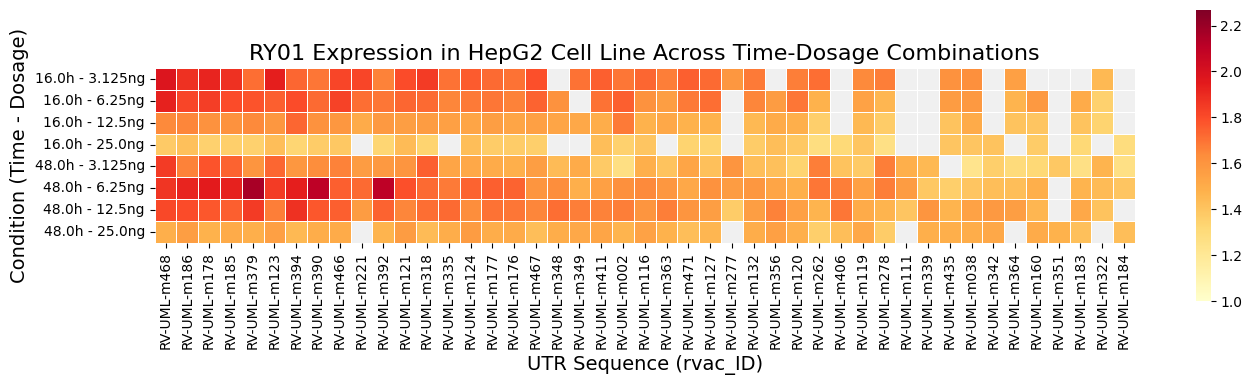


HepG2细胞系中RY01表现最好的UTR序列：
rvac_ID
RV-UML-m468    1.74375
RV-UML-m186    1.71375
RV-UML-m178    1.71250
RV-UML-m185    1.69750
RV-UML-m379    1.69750
Name: Expression, dtype: float64

HepG2细胞系中RY01表现最好的时间点-剂量组合：
Condition
16.0h - 3.125ng    1.730000
16.0h - 6.25ng     1.665135
48.0h - 6.25ng     1.661364
48.0h - 12.5ng     1.629535
16.0h - 12.5ng     1.523947
Name: Expression, dtype: float64


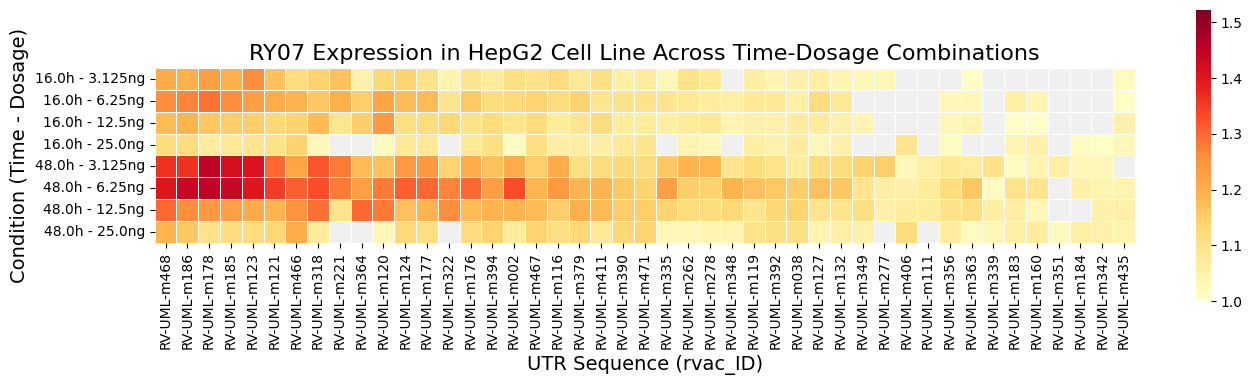


HepG2细胞系中RY07表现最好的UTR序列：
rvac_ID
RV-UML-m468    1.25250
RV-UML-m186    1.25000
RV-UML-m178    1.24875
RV-UML-m185    1.23750
RV-UML-m123    1.23375
Name: Expression, dtype: float64

HepG2细胞系中RY07表现最好的时间点-剂量组合：
Condition
48.0h - 6.25ng     1.208409
48.0h - 3.125ng    1.170227
48.0h - 12.5ng     1.154651
16.0h - 6.25ng     1.131892
16.0h - 3.125ng    1.100571
Name: Expression, dtype: float64

分析 C2C12 细胞系...


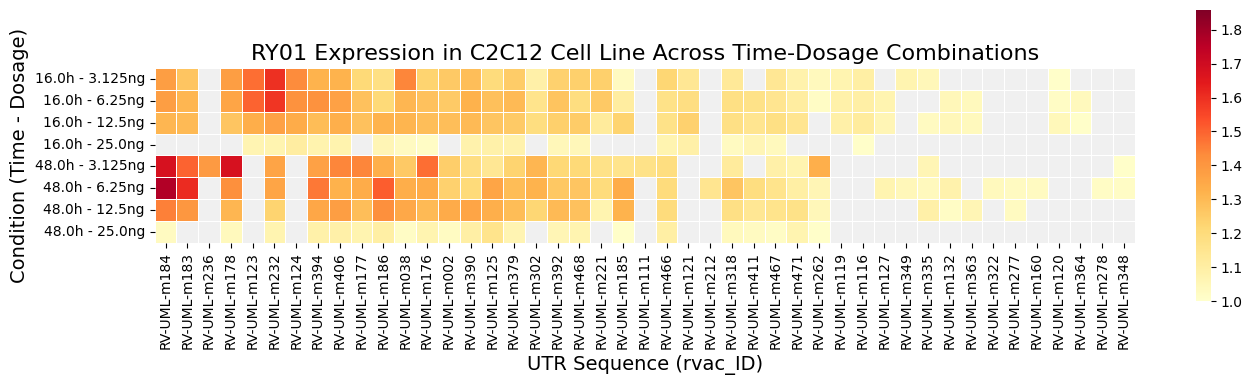


C2C12细胞系中RY01表现最好的UTR序列：
rvac_ID
RV-UML-m184    1.428571
RV-UML-m183    1.398333
RV-UML-m236    1.390000
RV-UML-m178    1.351429
RV-UML-m123    1.345000
Name: Expression, dtype: float64

C2C12细胞系中RY01表现最好的时间点-剂量组合：
Condition
48.0h - 3.125ng    1.280060
48.0h - 12.5ng     1.244828
48.0h - 6.25ng     1.242095
16.0h - 6.25ng     1.227476
16.0h - 3.125ng    1.222708
Name: Expression, dtype: float64


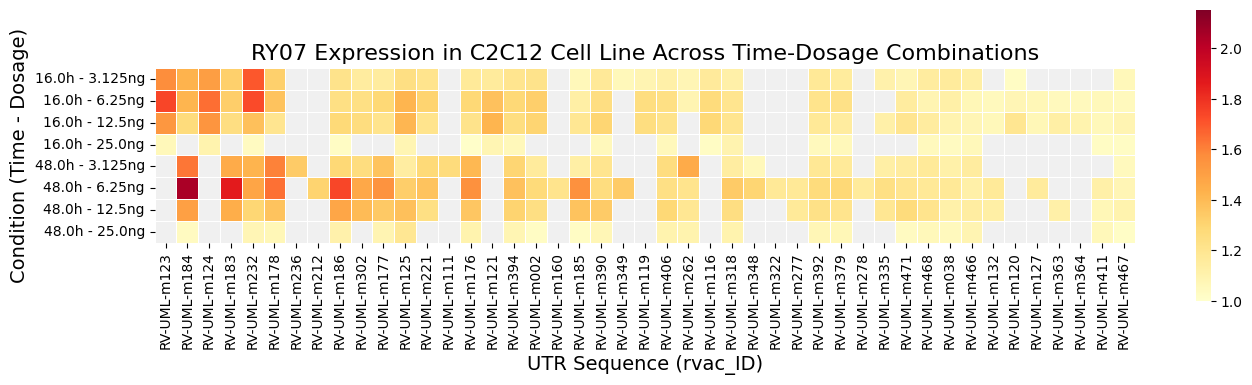


C2C12细胞系中RY07表现最好的UTR序列：
rvac_ID
RV-UML-m123    1.480000
RV-UML-m184    1.477143
RV-UML-m124    1.450000
RV-UML-m183    1.445000
RV-UML-m232    1.391875
Name: Expression, dtype: float64

C2C12细胞系中RY07表现最好的时间点-剂量组合：
Condition
48.0h - 6.25ng     1.342714
48.0h - 12.5ng     1.268218
48.0h - 3.125ng    1.261012
16.0h - 6.25ng     1.249810
16.0h - 12.5ng     1.225524
Name: Expression, dtype: float64
热图分析完成！


In [58]:
'''
组合条件热图分析方法
这次分析的主要目标是探究不同实验条件组合对UTR表达水平的影响，我们采用了以下方法：
数据处理与分析流程

数据筛选与转换：

首先筛选出RY01和RY07表达水平都大于1的高表达序列
将时间点和剂量转换为浮点数，确保正确排序
创建"时间点-剂量"组合条件标签，格式为"48.0h - 6.25ng"


序列优先级筛选：

计算每个序列在RY01和RY07两个基准下的平均表达值
选取表现最佳的前30个UTR序列进行后续分析
这确保热图聚焦于最有研究价值的序列


按细胞系分组分析：

将数据按不同细胞系分开处理
针对每个细胞系，分别为RY01和RY07创建热图
这种方法使我们能够清晰地看到特定细胞系中的表达模式


条件排序优化：

实验条件先按时间点升序排列，再按剂量升序排列
序列按平均表达水平降序排列
这种双重排序确保热图有序呈现，便于观察规律
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_combined_dimensions(data):
    """
    按细胞系分别生成时间点-剂量组合的热图
    data: 包含UTR表达数据的DataFrame
    """
    print("生成组合维度热图分析...")
    
    # 筛选出RY01和RY07都>1的序列
    both_high = data[(data['RY01_FC_log2RLU'] > 1) & (data['RY07_FC_log2RLU'] > 1)]
    print(f"找到 {len(both_high)} 个在RY01和RY07中都高表达的序列")
    
    # 创建组合条件标签 (时间点-剂量)，确保正确排序
    both_high['Time'] = both_high['Time Points(h)'].astype(float)
    both_high['Dosage'] = both_high['Dosage (ng)'].astype(float)
    both_high['Condition'] = both_high['Time'].astype(str) + 'h - ' + both_high['Dosage'].astype(str) + 'ng'
    
    # 按平均表达值找出表现最好的序列
    seq_performance = both_high.groupby('rvac_ID')[['RY01_FC_log2RLU', 'RY07_FC_log2RLU']].mean()
    seq_performance['avg'] = (seq_performance['RY01_FC_log2RLU'] + seq_performance['RY07_FC_log2RLU']) / 2
    top_sequences = seq_performance.sort_values('avg', ascending=False).head(50).index.tolist()
    
    # 筛选顶级序列
    filtered_data = both_high[both_high['rvac_ID'].isin(top_sequences)]
    
    # 获取所有细胞系
    cell_lines = filtered_data['Cell_Line'].unique()
    
    # 为每个细胞系分别创建热图
    for cell_line in cell_lines:
        cell_data = filtered_data[filtered_data['Cell_Line'] == cell_line]
        
        if len(cell_data) > 0:
            print(f"\n分析 {cell_line} 细胞系...")
            
            # 创建两个图 (RY01 和 RY07)
            create_cell_line_heatmap(cell_data, cell_line, top_sequences, 'RY01_FC_log2RLU', 'RY01')
            create_cell_line_heatmap(cell_data, cell_line, top_sequences, 'RY07_FC_log2RLU', 'RY07')
    
    # 保存最佳序列和条件组合信息
    cell_sequence_data = []
    cell_condition_data = []
    
    for cell_line in cell_lines:
        cell_data = filtered_data[filtered_data['Cell_Line'] == cell_line]
        
        if len(cell_data) > 0:
            # RY01数据
            ry01_by_seq = cell_data.groupby('rvac_ID')['RY01_FC_log2RLU'].mean().sort_values(ascending=False)
            ry01_by_cond = cell_data.groupby('Condition')['RY01_FC_log2RLU'].mean().sort_values(ascending=False)
            
            for seq, value in ry01_by_seq.head(10).items():
                cell_sequence_data.append({
                    'Cell_Line': cell_line,
                    'Benchmark': 'RY01',
                    'rvac_ID': seq,
                    'Mean_Expression': value
                })
                
            for cond, value in ry01_by_cond.head(5).items():
                cell_condition_data.append({
                    'Cell_Line': cell_line,
                    'Benchmark': 'RY01',
                    'Condition': cond,
                    'Mean_Expression': value
                })
            
            # RY07数据
            ry07_by_seq = cell_data.groupby('rvac_ID')['RY07_FC_log2RLU'].mean().sort_values(ascending=False)
            ry07_by_cond = cell_data.groupby('Condition')['RY07_FC_log2RLU'].mean().sort_values(ascending=False)
            
            for seq, value in ry07_by_seq.head(10).items():
                cell_sequence_data.append({
                    'Cell_Line': cell_line,
                    'Benchmark': 'RY07',
                    'rvac_ID': seq,
                    'Mean_Expression': value
                })
                
            for cond, value in ry07_by_cond.head(5).items():
                cell_condition_data.append({
                    'Cell_Line': cell_line,
                    'Benchmark': 'RY07',
                    'Condition': cond,
                    'Mean_Expression': value
                })
    
    # 保存为CSV文件
    seq_df = pd.DataFrame(cell_sequence_data)
    cond_df = pd.DataFrame(cell_condition_data)
    
    seq_df.to_csv('./UTR_sequences/vMay16_Best_Sequences_By_CellLine.csv', index=False)
    cond_df.to_csv('./UTR_sequences/vMay16_Best_Conditions_By_CellLine.csv', index=False)
    
    print("热图分析完成！")

def create_cell_line_heatmap(cell_data, cell_line, top_sequences, target_column, benchmark):
    """
    为特定细胞系创建时间点-剂量组合的热图
    """
    # 准备热图数据
    heatmap_data = []
    
    # 获取所有时间点-剂量组合
    conditions = cell_data['Condition'].unique()
    
    # 对条件进行排序 - 先按时间排序，然后按剂量排序
    def sort_key(cond):
        parts = cond.split(' - ')
        time = float(parts[0].replace('h', ''))
        dosage = float(parts[1].replace('ng', ''))
        return (time, dosage)
    
    sorted_conditions = sorted(conditions, key=sort_key)
    
    # 遍历每个序列和条件组合
    for seq in top_sequences:
        seq_data = cell_data[cell_data['rvac_ID'] == seq]
        
        for condition in sorted_conditions:
            cond_data = seq_data[seq_data['Condition'] == condition]
            
            if not cond_data.empty:
                expr_val = cond_data[target_column].mean()
                
                heatmap_data.append({
                    'rvac_ID': seq,
                    'Condition': condition,
                    'Expression': expr_val
                })
    
    # 转换为DataFrame
    hm_df = pd.DataFrame(heatmap_data)
    
    # 如果数据为空，提示并返回
    if hm_df.empty:
        print(f"  没有足够的数据生成{cell_line}细胞系的{benchmark}热图")
        return
    
    # 创建热图
    plt.figure(figsize=(14, 10))
    
    # 设置背景颜色
    ax = plt.gca()
    ax.set_facecolor('#f0f0f0')
    
    # 创建热图数据
    pivot_data = pd.pivot_table(hm_df, values='Expression', index='Condition', columns='rvac_ID')
    
    # 按条件排序 - 确保与sorted_conditions顺序一致
    pivot_data = pivot_data.reindex(sorted_conditions)
    
    # 按平均值排序列 (序列)
    col_means = pivot_data.mean()
    pivot_data = pivot_data[col_means.sort_values(ascending=False).index]
    
    # 为缺失值创建掩码
    mask = pivot_data.isna()
    
    # 设置颜色范围
    vmin = 1.0
    vmax = min(3.0, pivot_data.max().max() * 1.05)
    
    # 生成热图
    cbar_kws = {"shrink": 0.3}  # 使颜色条高度是热图的一半
    sns.heatmap(pivot_data, cmap='YlOrRd', vmin=vmin, vmax=vmax,
               annot=False, fmt='.2f', linewidths=.5, 
               cbar_kws=cbar_kws, square=True,
               ax=ax, mask=mask)
    
    plt.title(f'{benchmark} Expression in {cell_line} Cell Line Across Time-Dosage Combinations', fontsize=16)
    plt.ylabel('Condition (Time - Dosage)', fontsize=14)
    plt.xlabel('UTR Sequence (rvac_ID)', fontsize=14)
    
    # 旋转x轴标签
    plt.xticks(rotation=90)
    
    # 调整Y轴标签对齐方向
    plt.yticks(rotation=0)
    
    # 关闭默认网格
    ax.grid(False)
    
    plt.tight_layout()
    # 保存到UTR_sequences文件夹
    plt.savefig(f'./UTR_sequences/vMay16_{benchmark}_{cell_line}_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 输出在该细胞系下表现最好的序列
    avg_by_seq = hm_df.groupby('rvac_ID')['Expression'].mean().sort_values(ascending=False)
    avg_by_cond = hm_df.groupby('Condition')['Expression'].mean().sort_values(ascending=False)
    
    print(f"\n{cell_line}细胞系中{benchmark}表现最好的UTR序列：")
    print(avg_by_seq.head(5))
    
    print(f"\n{cell_line}细胞系中{benchmark}表现最好的时间点-剂量组合：")
    print(avg_by_cond.head(5))

# 使用方法
analyze_combined_dimensions(data)


表现最稳定的序列（变异系数最小）：
         rvac_ID   RY01_CV   RY07_CV  Average_CV  RY01_Mean  RY07_Mean  \
52   RV-UML-m053  1.167884  3.681110    2.424497    0.99750    1.03125   
0    RV-UML-m001  2.602281  2.437303    2.519792    0.98375    1.00500   
73   RV-UML-m074  1.653162  3.403309    2.528235    0.97000    0.99875   
76   RV-UML-m077  3.472853  1.627837    2.550345    0.97875    1.00875   
334  RV-UML-m341  1.920554  3.282152    2.601353    0.94125    1.03000   
106  RV-UML-m107  2.459148  2.895395    2.677272    0.88125    0.97250   
64   RV-UML-m065  3.182990  2.191435    2.687212    0.93500    0.97375   
20   RV-UML-m021  4.190091  1.244867    2.717479    0.95250    1.00125   
448  RV-UML-m457  3.295018  2.185627    2.740322    1.00000    1.02125   
23   RV-UML-m024  4.372760  1.208653    2.790707    0.98125    1.03125   

     Average_Mean  Sample_Count  
52       1.014375             8  
0        0.994375             8  
73       0.984375             8  
76       0.993750             

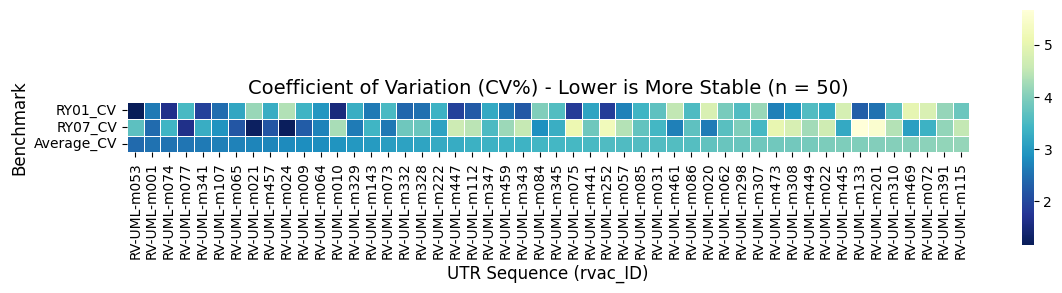

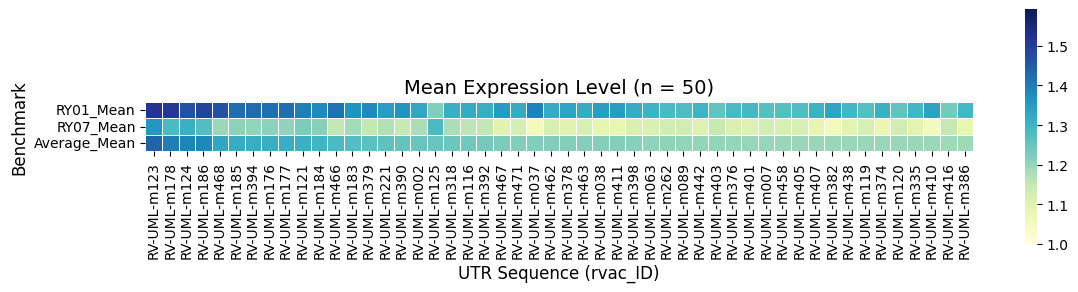


表现优异的序列（稳定性高且表达水平高）：
序列 RV-UML-m053:
  平均变异系数(CV): 2.42%
  平均表达水平: 1.01
  RY01变异系数: 1.17%, RY01表达水平: 1.00
  RY07变异系数: 3.68%, RY07表达水平: 1.03
  样本数量: 8

序列 RV-UML-m001:
  平均变异系数(CV): 2.52%
  平均表达水平: 0.99
  RY01变异系数: 2.60%, RY01表达水平: 0.98
  RY07变异系数: 2.44%, RY07表达水平: 1.00
  样本数量: 8

序列 RV-UML-m074:
  平均变异系数(CV): 2.53%
  平均表达水平: 0.98
  RY01变异系数: 1.65%, RY01表达水平: 0.97
  RY07变异系数: 3.40%, RY07表达水平: 1.00
  样本数量: 8

序列 RV-UML-m077:
  平均变异系数(CV): 2.55%
  平均表达水平: 0.99
  RY01变异系数: 3.47%, RY01表达水平: 0.98
  RY07变异系数: 1.63%, RY07表达水平: 1.01
  样本数量: 8

序列 RV-UML-m341:
  平均变异系数(CV): 2.60%
  平均表达水平: 0.99
  RY01变异系数: 1.92%, RY01表达水平: 0.94
  RY07变异系数: 3.28%, RY07表达水平: 1.03
  样本数量: 8



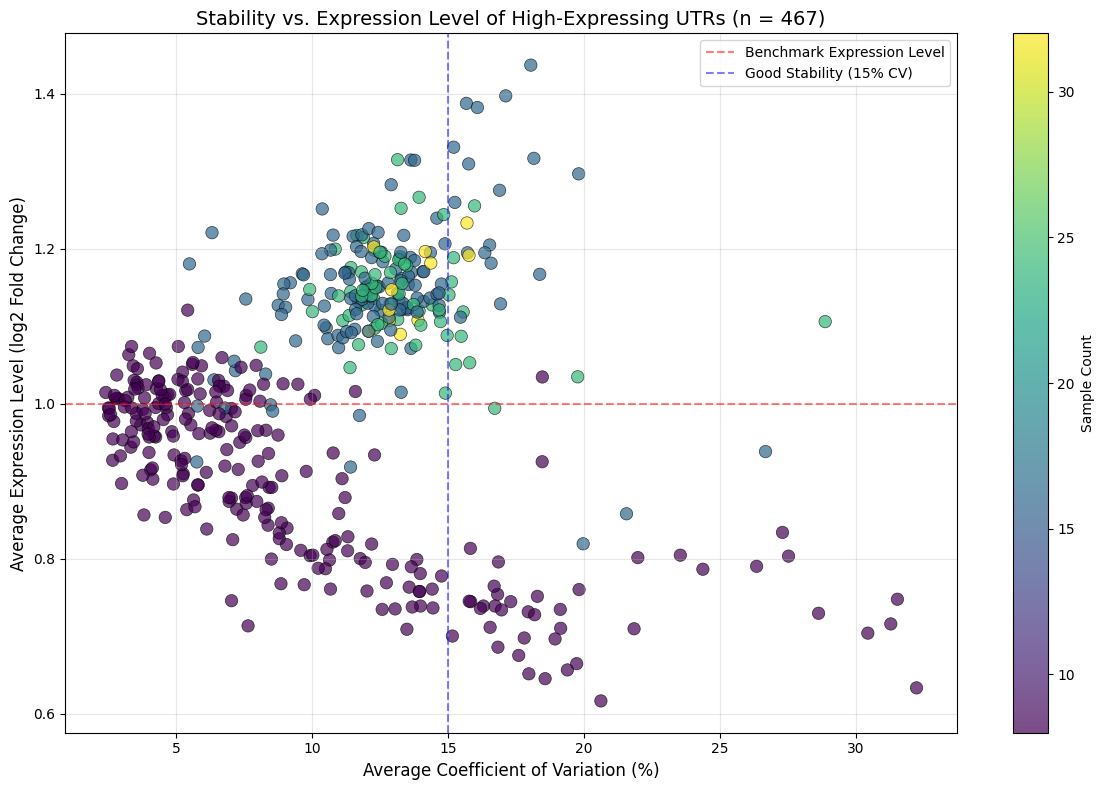

In [54]:
'''
UTR序列稳定性与表达水平分析
本分析对潜在高表达UTR序列进行了系统性评估，重点考察了序列表达水平的稳定性与强度这两个关键特性。我们基于变异系数(CV%)和平均表达水平创建了多维度的可视化分析，从不同角度评估序列表现。
在稳定性分析中，我们计算了每个序列在RY01和RY07两个基准下的变异系数，该指标反映了序列在不同实验条件下表达水平的波动程度。较低的CV%值表示序列表现更加稳定，不受环境条件变化的影响，这对于实际应用至关重要。热图直观地展示了变异系数最低的50个序列，深色区域代表更稳定的表现。
表达水平分析关注了序列在两个基准下的平均表达强度，独立筛选出表达水平最高的50个序列。值得注意的是，高表达序列与高稳定性序列并不完全重合，这反映了UTR功能的多样性和复杂性。
最后，我们通过散点图综合展示了所有序列的稳定性与表达水平关系，明确了基准表达水平（log2FC=1.0）和良好稳定性阈值（CV=15%）。图中点的颜色代表每个序列的样本数量，帮助评估数据可靠性。散点图特别有助于识别那些兼具高表达和高稳定性的"理想"序列，这些序列位于图的右下区域，表现出低变异系数和高表达水平的特性。
通过这种多角度分析，我们可以更全面地了解UTR序列在不同条件下的表现模式，为后续实验设计和序列筛选提供重要依据。特别是那些既高表达又高稳定的序列，将是进一步研究和应用的首选目标。
'''
def analyze_sequence_stability(data):
    """分析序列在不同条件下的稳定性"""
    # 计算每个序列在不同条件下的变异系数(CV)
    # 只包括至少有5个数据点的序列，以确保CV计算可靠
    seq_counts = data.groupby('rvac_ID').size()
    reliable_seqs = seq_counts[seq_counts >= 5].index.tolist()
    
    if len(reliable_seqs) < 5:
        print("没有足够多的序列有足够数据点来分析稳定性")
        return
        
    filtered_data = data[data['rvac_ID'].isin(reliable_seqs)]
    
    stability_data = []
    for seq in reliable_seqs:
        seq_data = filtered_data[filtered_data['rvac_ID'] == seq]
        
        ry01_cv = seq_data['RY01_FC_log2RLU'].std() / seq_data['RY01_FC_log2RLU'].mean() * 100 if seq_data['RY01_FC_log2RLU'].mean() > 0 else float('inf')
        ry07_cv = seq_data['RY07_FC_log2RLU'].std() / seq_data['RY07_FC_log2RLU'].mean() * 100 if seq_data['RY07_FC_log2RLU'].mean() > 0 else float('inf')
        
        stability_data.append({
            'rvac_ID': seq,
            'RY01_CV': ry01_cv,
            'RY07_CV': ry07_cv,
            'RY01_Mean': seq_data['RY01_FC_log2RLU'].mean(),
            'RY07_Mean': seq_data['RY07_FC_log2RLU'].mean(),
            'Sample_Count': len(seq_data),
            'Average_CV': (ry01_cv + ry07_cv) / 2,
            'Average_Mean': (seq_data['RY01_FC_log2RLU'].mean() + seq_data['RY07_FC_log2RLU'].mean()) / 2
        })
    
    # 创建DataFrame并排序
    stab_df = pd.DataFrame(stability_data)
    
    # 显示最稳定的序列
    print("\n表现最稳定的序列（变异系数最小）：")
    print(stab_df.sort_values(by='Average_CV')[['rvac_ID', 'RY01_CV', 'RY07_CV', 'Average_CV', 'RY01_Mean', 'RY07_Mean', 'Average_Mean', 'Sample_Count']].head(10))
    
    # 创建CV热图数据 - 取前50个最稳定的序列
    cv_df = stab_df.sort_values(by='Average_CV').head(50)
    
    # 准备CV热图数据
    cv_data = pd.DataFrame({
        'rvac_ID': cv_df['rvac_ID'],
        'RY01_CV': cv_df['RY01_CV'],
        'RY07_CV': cv_df['RY07_CV'],
        'Average_CV': cv_df['Average_CV']
    })
    cv_pivot = cv_data.set_index('rvac_ID').T  # 转置，使rvac_ID在横轴
    
    # 创建表达水平热图数据 - 独立选择表达水平最高的50个序列
    mean_df = stab_df.sort_values(by='Average_Mean', ascending=False).head(50)
    
    # 准备表达水平热图数据
    mean_data = pd.DataFrame({
        'rvac_ID': mean_df['rvac_ID'],
        'RY01_Mean': mean_df['RY01_Mean'],
        'RY07_Mean': mean_df['RY07_Mean'],
        'Average_Mean': mean_df['Average_Mean']
    })
    mean_pivot = mean_data.set_index('rvac_ID').T  # 转置，使rvac_ID在横轴
    
    # 创建CV热图
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # 设置背景颜色为浅灰色
    ax.set_facecolor('#f0f0f0')
    
    # 为缺失值创建掩码
    mask = cv_pivot.isna()
    
    # 生成CV热图 - 使用反转的颜色映射（越低越好）
    cbar_kws = {"shrink": 0.5}  # 使颜色条高度是热图的一半
    sns.heatmap(cv_pivot, cmap='YlGnBu_r', annot=False, linewidths=.5, 
                mask=mask, square=True, ax=ax, cbar_kws=cbar_kws)
    plt.title(f'Coefficient of Variation (CV%) - Lower is More Stable (n = {len(cv_df)})', fontsize=14)
    plt.xlabel('UTR Sequence (rvac_ID)', fontsize=12)
    plt.ylabel('Benchmark', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./UTR_sequences/vMay16_CV_Heatmap.png', dpi=300)
    plt.show()
    
    # 创建表达水平热图
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # 设置背景颜色
    ax.set_facecolor('#f0f0f0')
    
    # 为缺失值创建掩码
    mask = mean_pivot.isna()
    
    # 设置颜色范围
    vmin = 1.0
    vmax = min(3.0, mean_pivot.max().max() * 1.05)
    
    # 生成表达水平热图
    cbar_kws = {"shrink": 0.5}  # 使颜色条高度是热图的一半
    sns.heatmap(mean_pivot, cmap='YlGnBu', vmin=vmin, vmax=vmax,
                annot=False, linewidths=.5, mask=mask, square=True, 
                ax=ax, cbar_kws=cbar_kws)
    plt.title(f'Mean Expression Level (n = {len(mean_df)})', fontsize=14)
    plt.xlabel('UTR Sequence (rvac_ID)', fontsize=12)
    plt.ylabel('Benchmark', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig('./UTR_sequences/vMay16_Expression_Heatmap.png', dpi=300)
    plt.show()
    
    # 创建稳定性与表达水平的散点图
    # 移除极端CV值以提高可视化效果
    plot_df = stab_df[stab_df['Average_CV'] < 50].copy()  # 只显示CV<50%的序列
    
    plt.figure(figsize=(12, 8))
    
    # 设置背景网格
    plt.grid(True, alpha=0.3)
    
    # 创建散点图，使用颜色区分表达水平，统一大小
    scatter = plt.scatter(plot_df['Average_CV'], plot_df['Average_Mean'], 
                       c=plot_df['Sample_Count'], cmap='viridis', 
                       s=80, alpha=0.7, edgecolors='k', linewidths=0.5)
    
    # 输出表现优异的序列信息（不在图上标注）
    best_seqs = plot_df.sort_values(by=['Average_CV', 'Average_Mean'], 
                                  ascending=[True, False]).head(5)
    
    print("\n表现优异的序列（稳定性高且表达水平高）：")
    for idx, row in best_seqs.iterrows():
        print(f"序列 {row['rvac_ID']}:")
        print(f"  平均变异系数(CV): {row['Average_CV']:.2f}%")
        print(f"  平均表达水平: {row['Average_Mean']:.2f}")
        print(f"  RY01变异系数: {row['RY01_CV']:.2f}%, RY01表达水平: {row['RY01_Mean']:.2f}")
        print(f"  RY07变异系数: {row['RY07_CV']:.2f}%, RY07表达水平: {row['RY07_Mean']:.2f}")
        print(f"  样本数量: {row['Sample_Count']}")
        print("")
    
    # 添加颜色条，显示样本数量
    cbar = plt.colorbar(scatter)
    cbar.set_label('Sample Count', fontsize=10)
    
    plt.xlabel('Average Coefficient of Variation (%)', fontsize=12)
    plt.ylabel('Average Expression Level (log2 Fold Change)', fontsize=12)
    plt.title(f'Stability vs. Expression Level of High-Expressing UTRs (n = {len(plot_df)})', fontsize=14)
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Benchmark Expression Level')
    plt.axvline(x=15, color='b', linestyle='--', alpha=0.5, label='Good Stability (15% CV)')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig('./UTR_sequences/vMay16_Stability.png', dpi=300)
    plt.show()
    
    # 将最优序列信息保存到CSV文件
    top_seqs = plot_df.sort_values(by=['Average_CV', 'Average_Mean'], 
                                ascending=[True, False]).head(20)
    top_seqs.to_csv('./UTR_sequences/vMay16_Top_Stable_Sequences.csv', index=False)
    
    # 保存各个序列的排名信息
    cv_rank = stab_df[['rvac_ID', 'Average_CV']].sort_values('Average_CV')
    cv_rank['CV_Rank'] = range(1, len(cv_rank) + 1)
    
    expr_rank = stab_df[['rvac_ID', 'Average_Mean']].sort_values('Average_Mean', ascending=False)
    expr_rank['Expression_Rank'] = range(1, len(expr_rank) + 1)
    
    # 合并排名
    rankings = pd.merge(cv_rank, expr_rank, on='rvac_ID')
    rankings['Combined_Score'] = rankings['CV_Rank'] + rankings['Expression_Rank']
    rankings = rankings.sort_values('Combined_Score')
    rankings.to_csv('./UTR_sequences/vMay16_Sequence_Rankings.csv', index=False)

# 使用方法
analyze_sequence_stability(data)